# Is the opinion of the crowd on movies just as good as that of critics?

On a spring morning in 1906, Frank Galton attended a weight-judging competition at an annual exhibition of the West of England Fat Stock and Poultry at Plymouth. This was a farmers' fair where all sorts of crop and animal products were on display and sold. A fat ox had been selected for slaughter, and participants were provided a card on which to write their names, addresses and estimates of what the ox would weigh after it is slaughtered and "dressed". Those with successful guesses would receive a prize[1]. While most may have considered their participation trivial and of no consequence, Galton thought the combined results would make for a good experiment. He collated the results and ran statistical analysis on them. He found that the "middlemost" estimate was very close to the actual weight of the slaughtered ox: it was correct to within 1% of the actual value. While the estimate was 1207-lb, the actual weight of the dressed ox was 1198-lb. In effect, while most of the participants in the guessing competition may have guessed wrongly, their combined effort produced a result close enough to the actual value.

Though crowd behaviour can sometimes be fickle or irrational, in certain cases, such as with Galton's experiment, it provides interesting global estimates. In some situations, a diverse and independently sampled opinion of a crowd could in fact reflect the "truth". This logic has been successfully exploited in election polls, internet search engines, stock market predictions, and online knowledge repositories such as Wikipedia. In this project, we examine just how true this supposition is with movie ratings.

IMDb and Rotten Tomatoes are some of the biggest movie aggregators online. Both collect ratings and other details on movies and TV shows, making these accessible to their global audience. However, while the former collects its movie ratings mainly from the crowd, the latter uses a score based strictly on the opinion of critics in the movie industry. These two contrasting techniques of judging a movie pits the crowd against critics, and makes for an interesting comparison of the two opinions. Would the "wisdom of crowds" produce a rating for a movie just as good as that from seasoned experts? We examined the data to see what insights are present.

After collecting 9,638 movies from Rotten Tomatoes and 44,239 movies from IMDb, we identified 3,171 unique movies common to both which include ratings from both websites. Using this data, we examined the relationship between the ratings provided by the crowd on IMDb and those provided by critics on Rotten Tomatoes.

This project was conducted by Ade Banjo-Schultz, Raka Shar, Tony Ng and Mark Meritt as part of a final project for University of Toronto's Machine Learning course.

## Sections
- [1. Data Loading](#1) 
- [2. Data Preparation](#2)
- [3. Feature Extraction and Modification](#3)
- [4. Exploratory Data Analysis](#4)
- [5. Question Assessment](#5)
- [6. Model Building](#6)
- [7. Model Evaluation](#7)
- [8. References](#8)
- [9. Appendix A](#9)
- [10. Appendix B](#10)

<a id='1'></a>

## **Data Loading**

In [267]:
#get file from google drive
%%time
!pip install googledrivedownloader #black magic
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id="1bigp3mpH-RHIakPZfjWmeGARlk-0axVY",
                                    dest_path="./rottentomatoes.csv",
                                    unzip=False)

gdd.download_file_from_google_drive(file_id="1e8_vvdVVnB_zjW74zUYmKymq8TbDGVZ_",
                                    dest_path="./imdb.csv",
                                    unzip=False)

gdd.download_file_from_google_drive(file_id="1jPxxgPIiz9YWq8nwwPa37I_bQh8G0HzC",
                                    dest_path="./topactors.csv",
                                    unzip=False)

CPU times: user 77.7 ms, sys: 16.6 ms, total: 94.3 ms
Wall time: 11.1 s


In [268]:
#Load required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns; sns.set_style('whitegrid')


### Rotten Tomatoes Dataset

Import Rotten Tomatoes data

In [269]:
rt = pd.read_csv('rottentomatoes.csv')
rt.drop(columns="Unnamed: 0", axis=1, inplace=True)
rt.head(2)

,movieTitle,tMeterScore,link,actors,boxOffice,directedBy,genre,inTheaters,onDiscStreaming,rating,runtime,studio,writtenBy
0,Game of Death,63%,https://www.rottentomatoes.com/m/game_of_death...,"Sam Earle, Victoria Diamond",NaN,"Sébastien Landry, Laurence Morais-Lagace","Horror, Mystery & Suspense","Jul 14, 2020 limited","Jul 14, 2020",NR,73 minutes,Cleopatra Entertainment,"Edouard H. Bond, Philip Kalin-Hajdu, Laurence ..."
1,MILF,17%,https://www.rottentomatoes.com/m/milf_2018,"Axelle Laffont, Virginie Ledoyen",NaN,Axelle Laffont,"Art House & International, Comedy","Jul 14, 2020 limited","Jul 16, 2020",NR,101 minutes,Netflix,"Jerome L'Hotsky, Stéphane Kramer, Axelle Laffo..."


Examine details of data

In [270]:
rt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9638 entries, 0 to 9637
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   movieTitle       9638 non-null   object
 1   tMeterScore      9638 non-null   object
 2   link             9638 non-null   object
 3   actors           9638 non-null   object
 4   boxOffice        9229 non-null   object
 5   directedBy       9638 non-null   object
 6   genre            9638 non-null   object
 7   inTheaters       9638 non-null   object
 8   onDiscStreaming  9638 non-null   object
 9   rating           9638 non-null   object
 10  runtime          9638 non-null   object
 11  studio           9638 non-null   object
 12  writtenBy        9638 non-null   object
dtypes: object(13)
memory usage: 979.0+ KB


### IMDB data set 
URL :- https://www.imdb.com/search/title/?release_date=2019-01-01,2020-07-25&count=250

Import IMDb data

In [271]:
imdb = pd.read_csv('imdb.csv')
imdb.drop(columns="Unnamed: 0", axis=1, inplace=True)
imdb.head(2)

,name,year,rating,metascore,votes
0,The Matrix,(1999),8.7,73.0,"1,624,599"
1,Black Panther,(2018),7.3,88.0,"589,932"


In [272]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44239 entries, 0 to 44238
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       44239 non-null  object 
 1   year       38025 non-null  object 
 2   rating     35850 non-null  float64
 3   metascore  11181 non-null  float64
 4   votes      35838 non-null  object 
dtypes: float64(2), object(3)
memory usage: 1.7+ MB


<a id='2'></a>

## **Data Preparation**

Prior to conducting any analysis, we need to clean and prepare both data sets. Some of the features are not as useful as the others. Similarly, some features need to be properly edited. 

For each data set, we create an identifier which unique identifies a movie. We use **Movie Name (Release Year)** to identify each movie in both data sets.

In [273]:
#Extract year information from "inTheaters" feature in RT data set
yrs = rt.inTheaters.str.extract('(\d{4})')
yrs = pd.Series(yrs.values.ravel())
yrs.head()

0    2020
1    2020
2    2020
3    2020
4    2020
dtype: object

In [274]:
rt['moviesWithYear'] = rt.movieTitle.combine(yrs, lambda x,y: x + "(" + str(y) + ")")

In [275]:
#Strip spaces from movie titles in RT data set
rt.loc[:, 'movieTitle'] = rt.movieTitle.str.strip()

In [276]:
#Extract year information from movies in IMDb data set
yrs_ = pd.Series(imdb.year.str.extract('(\d{4})').values.ravel())
yrs_.head()

0    1999
1    2018
2    2010
3    2016
4    2017
dtype: object

In [277]:
imdb['moviesWithYear'] = imdb.name.combine(yrs_, lambda x,y: x + " (" + str(y) + ")")

In [278]:
#Extract year
imdb['year'] = imdb.year.str.extract('(\d{4})')

It appears there are still some duplicate movies in the data set as shown below.
We need to remove the duplicated movies. Of the duplicates, we will retain the movies with the highest votes.

In [279]:
imdb[imdb.name.isin(imdb[imdb.duplicated(subset=['moviesWithYear'])].name)].sort_values('name') #Identify the duplicates

,name,year,rating,metascore,votes,moviesWithYear
20607,1066,NaN,NaN,NaN,NaN,1066 (nan)
3510,1066,NaN,NaN,NaN,NaN,1066 (nan)
31327,22,NaN,NaN,NaN,NaN,22 (nan)
12107,22,NaN,NaN,NaN,NaN,22 (nan)
25689,Abducted,NaN,NaN,NaN,NaN,Abducted (nan)
...,...,...,...,...,...,...
3121,Z,NaN,NaN,NaN,NaN,Z (nan)
44224,Z,2019,5.6,63.0,"1,739",Z (2019)
18135,Zorro,1975,5.3,NaN,30,Zorro (1975)
2021,Zorro,1975,6.6,NaN,"3,020",Zorro (1975)


In [280]:
#Fill in zero for movies without votes
imdb['votes'] = imdb.votes.fillna(value=0)

#Replace commas with space in votes
imdb['votes'] = imdb.votes.str.replace(',','')

In [281]:
imdb_duplicated = imdb[imdb.name.isin(imdb[imdb.duplicated(subset=['moviesWithYear'])].name)].sort_values(by='moviesWithYear') #Get duplicated movies
imdb_duplicated

,name,year,rating,metascore,votes,moviesWithYear
20607,1066,NaN,NaN,NaN,NaN,1066 (nan)
3510,1066,NaN,NaN,NaN,NaN,1066 (nan)
12107,22,NaN,NaN,NaN,NaN,22 (nan)
31327,22,NaN,NaN,NaN,NaN,22 (nan)
4622,Abducted,2014,3.4,NaN,337,Abducted (2014)
...,...,...,...,...,...,...
29208,Z,NaN,NaN,NaN,NaN,Z (nan)
3121,Z,NaN,NaN,NaN,NaN,Z (nan)
18135,Zorro,1975,5.3,NaN,30,Zorro (1975)
2021,Zorro,1975,6.6,NaN,3020,Zorro (1975)


In [282]:
imdb_duplicated.votes.fillna(value=0, inplace=True) #Fill movies with no votes with vote=0
imdb_duplicated.votes = imdb_duplicated.votes.astype('int')

In [283]:
imdb_duplicated_true = imdb_duplicated.sort_values(by='votes').drop_duplicates(subset='moviesWithYear', keep='last') #Sort duplicates by votes

In [284]:
imdb_duplicated_true[imdb_duplicated_true.name == 'Weekend'] #Example of a movie with duplicates removed

,name,year,rating,metascore,votes,moviesWithYear
19024,Weekend,1998,4.4,NaN,68,Weekend (1998)
44185,Weekend,2011,7.6,81.0,27349,Weekend (2011)


In [285]:
imdb1 = imdb.copy()
imdb1.drop(labels=imdb_duplicated.index, inplace=True) #Drop duplicates from main dataframe

In [286]:
imdb1 = pd.concat([imdb1, imdb_duplicated_true]) #Append cleaned duplicates to main dataframe

In [287]:
imdb1.head()

,name,year,rating,metascore,votes,moviesWithYear
0,The Matrix,1999,8.7,73.0,1624599,The Matrix (1999)
1,Black Panther,2018,7.3,88.0,589932,Black Panther (2018)
2,The Last Airbender,2010,4.1,NaN,148633,The Last Airbender (2010)
3,Deadpool,2016,8.0,65.0,878685,Deadpool (2016)
4,Thor: Ragnarok,2017,7.9,74.0,560394,Thor: Ragnarok (2017)


In [288]:
imdb1.__len__() #Total length of unique sets

43965

Merge both data frames into one

In [289]:
#Merge both data frames
data = rt.merge(imdb1, on='moviesWithYear', how='inner')

In [290]:
#Extract Tomatometer Score from 'tMeterScore'
data.loc[:, 'tMeter'] = data.tMeterScore.str.extract('(\d{2})').values.ravel()

In [291]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3388 entries, 0 to 3387
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movieTitle       3388 non-null   object 
 1   tMeterScore      3388 non-null   object 
 2   link             3388 non-null   object 
 3   actors           3388 non-null   object 
 4   boxOffice        3265 non-null   object 
 5   directedBy       3388 non-null   object 
 6   genre            3388 non-null   object 
 7   inTheaters       3388 non-null   object 
 8   onDiscStreaming  3388 non-null   object 
 9   rating_x         3388 non-null   object 
 10  runtime          3388 non-null   object 
 11  studio           3388 non-null   object 
 12  writtenBy        3388 non-null   object 
 13  moviesWithYear   3388 non-null   object 
 14  name             3388 non-null   object 
 15  year             3388 non-null   object 
 16  rating_y         3388 non-null   float64
 17  metascore     

Before removing null values from `tMeter` and `rating_y`, the two features of concern, we have a data set of 3,392 records.

Examine null values present in data set

In [292]:
data.isnull().sum()

movieTitle           0
tMeterScore          0
link                 0
actors               0
boxOffice          123
directedBy           0
genre                0
inTheaters           0
onDiscStreaming      0
rating_x             0
runtime              0
studio               0
writtenBy            0
moviesWithYear       0
name                 0
year                 0
rating_y             0
metascore          202
votes                0
tMeter             220
dtype: int64

In [293]:
#We drop null values
data = data.dropna(subset=['tMeter', 'rating_y'], axis=0)

In [294]:
data.__len__()

3168

After removing null values, we have a data set with 3,171 records.

<a id='3'></a>

## **Feature Extraction and Modification**

Prior to working with the data, we prepare it and isolate the important features. There is presently a lot of text data, so we will be doing a handful of text extraction while retrieving the import features.

#### Add top actors as a feature

We create a new feature which checks if a top actor is in a movie. [IMDb](https://www.imdb.com/list/ls050274118/) provides information on the top 100 actors of all time. We propose that a movie's rating could be higher than the average, if a top actor is present.

In [295]:
from bs4 import BeautifulSoup
import requests

In [296]:
link = 'https://www.imdb.com/list/ls050274118/?sort=list_order,asc&mode=detail&page=1&ref_=nmls_vm_dtl'
response = requests.get(link)
html = response.content
bsObj = BeautifulSoup(html)

top_actors=[]
for item in bsObj.find_all(attrs={'class': 'lister-item mode-detail'}):
    top_actors+=[item.a.img['alt']]

topActors = pd.DataFrame(top_actors)
topActors.head()

,0
0,Jack Nicholson
1,Marlon Brando
2,Robert De Niro
3,Al Pacino
4,Daniel Day-Lewis


In [297]:
data['isTopActorIn'] = data.actors.str.split(',').apply(
    lambda x: 1 if set(x) & set(topActors.values.ravel()) else 0)

In [298]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3168 entries, 0 to 3387
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movieTitle       3168 non-null   object 
 1   tMeterScore      3168 non-null   object 
 2   link             3168 non-null   object 
 3   actors           3168 non-null   object 
 4   boxOffice        3053 non-null   object 
 5   directedBy       3168 non-null   object 
 6   genre            3168 non-null   object 
 7   inTheaters       3168 non-null   object 
 8   onDiscStreaming  3168 non-null   object 
 9   rating_x         3168 non-null   object 
 10  runtime          3168 non-null   object 
 11  studio           3168 non-null   object 
 12  writtenBy        3168 non-null   object 
 13  moviesWithYear   3168 non-null   object 
 14  name             3168 non-null   object 
 15  year             3168 non-null   object 
 16  rating_y         3168 non-null   float64
 17  metascore     

#### Add top directors as a feature

We create a new feature which checks if a movie is directed by a top director. Our list of top directors is provided by [IMDb](https://www.imdb.com/list/ls000050027/). We propose that a movie's rating could be higher than the average movie rating in the data set, if it is directed by a top director.



In [299]:
#Define link
link = "https://www.imdb.com/list/ls000050027/"

#Obtain beautifulSoup object
response = requests.get(link)
html = response.content
bsObj = BeautifulSoup(html)

#Get a list of top directors
top_directors=[]
for item in bsObj.find_all(attrs={'class': 'lister-item-header'}):
    top_directors+=[item.a.text.strip()]

In [300]:
topDirectors = pd.DataFrame(top_directors)
topDirectors.head()

,0
0,Stanley Kubrick
1,Alfred Hitchcock
2,David Lynch
3,Quentin Tarantino
4,Billy Wilder


In [301]:
data['isByTopDirector'] = data.directedBy.str.split(',').apply(
    lambda x: 1 if set(x) & set(topDirectors.values.ravel()) else 0)

In [302]:
data.head()

,movieTitle,tMeterScore,link,actors,boxOffice,directedBy,genre,inTheaters,onDiscStreaming,rating_x,runtime,studio,writtenBy,moviesWithYear,name,year,rating_y,metascore,votes,tMeter,isTopActorIn,isByTopDirector
0,Greyhound,79%,https://www.rottentomatoes.com/m/greyhound,"Tom Hanks, Stephen Graham",NaN,Aaron Schneider,"Action & Adventure, Drama","Jun 12, 2020 wide","Jul 10, 2020",PG-13 (for war-related action/violence and bri...,101 minutes,Apple TV+,Tom Hanks,Greyhound (2020),Greyhound,2020,7.1,63.0,33664,79,1,0
1,The Old Guard,81%,https://www.rottentomatoes.com/m/the_old_guard,"Charlize Theron, KiKi Layne",NaN,Gina Prince-Bythewood,"Action & Adventure, Mystery & Suspense, Scienc...","Jul 10, 2020 limited","Jul 10, 2020","R (for sequences of graphic violence, and lang...",125 minutes,Netflix,Greg Rucka,The Old Guard (2020),The Old Guard,2020,6.7,70.0,74417,81,0,0
2,Money Plane,27%,https://www.rottentomatoes.com/m/money_plane,"Adam Copeland, Denise Richards",NaN,Andrew Lawrence,"Action & Adventure, Mystery & Suspense","Jul 17, 2020 limited","Jul 10, 2020",NR,82 minutes,Quiver Distribution,Andrew Lawrence,Money Plane (2020),Money Plane,2020,3.3,NaN,357,27,0,0
3,Never Too Late,50%,https://www.rottentomatoes.com/m/never_too_lat...,"James Cromwell, Jacki Weaver",NaN,Mark Lamprell,"Comedy, Drama","Jul 10, 2020 limited","Jul 10, 2020",NR,98 minutes,Blue Fox Entertainment,Luke Preston,Never Too Late (2020),Never Too Late,2020,5.7,43.0,80,50,0,0
4,Miss Juneteenth,99%,https://www.rottentomatoes.com/m/miss_juneteenth,"Nicole Beharie, Kendrick Sampson",NaN,Channing Godfrey Peoples,Drama,"Jun 19, 2020 limited","Jun 19, 2020",NR,99 minutes,Sailor Bear,Channing Godfrey Peoples,Miss Juneteenth (2020),Miss Juneteenth,2020,6.0,73.0,452,99,0,0


We now have 3,171 records to work with.

Extract runtime minutes

In [303]:
#Extract runtime minutes
data.loc[:, "runtimeMins"] = data.runtime.str.extract('(\d+)').values

#Drop runtime column
data = data.drop(columns="runtime", axis=1)

Next, we extract the movie ratings

In [304]:
#Extract movie ratings
data.loc[:, 'movieRating'] = data.rating_x.str.extract('([A-Z\-0-9]+)').values

#Drop ratings column
data = data.drop(columns="rating_x", axis=1)

We use one-hot encoding to encode the `genre` attribute in the data set.

In [305]:
#Obtain a set of all categories
all_cats = set([i.strip() for i in '/ '.join(data.genre.str.replace('&', '/').str.replace(',','/')).split('/')])
all_cats

{'Action',
 'Adventure',
 'Animation',
 'Anime',
 'Art House',
 'Classics',
 'Comedy',
 'Cult Movies',
 'Documentary',
 'Drama',
 'Faith',
 'Family',
 'Fantasy',
 'Fitness',
 'Gay',
 'Horror',
 'International',
 'Kids',
 'Lesbian',
 'Manga',
 'Musical',
 'Mystery',
 'Performing Arts',
 'Romance',
 'Science Fiction',
 'Special Interest',
 'Spirituality',
 'Sports',
 'Suspense',
 'Television',
 'Western'}

In [306]:
#Obtain a list of all categories for each instance
xData = data.genre.str.replace('&', '/').str.replace(',','/').str.split('/').apply(lambda x: [i.strip() for i in x])
xData

0                              [Action, Adventure, Drama]
1       [Action, Adventure, Mystery, Suspense, Science...
2                  [Action, Adventure, Mystery, Suspense]
3                                         [Comedy, Drama]
4                                                 [Drama]
                              ...                        
3382                               [Comedy, Gay, Lesbian]
3383                                             [Comedy]
3384                 [Comedy, Mystery, Suspense, Romance]
3385                                             [Comedy]
3387                 [Classics, Drama, Mystery, Suspense]
Name: genre, Length: 3168, dtype: object

For each instance, we find the intersection of `all_cats` and the categories present. This will give us its genres.

In [307]:
#We create a new dataframe with the binary features
D = pd.DataFrame()
for cat in all_cats:
    D[cat] = xData.apply(lambda x: 1 if cat in x else 0)

In [308]:
D.head()

,Kids,Romance,Anime,Action,Fantasy,Family,Sports,Art House,Special Interest,Documentary,Science Fiction,Drama,Mystery,Comedy,Suspense,Cult Movies,Performing Arts,International,Western,Lesbian,Television,Classics,Manga,Faith,Spirituality,Musical,Gay,Animation,Fitness,Adventure,Horror
0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,1,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [309]:
#For example, in instance 24 is categorized as Comedy, Drama, and Romance:
data.iloc[23]

movieTitle                                            The Photograph
tMeterScore                                                      74%
link               https://www.rottentomatoes.com/m/the_photograp...
actors                                   Issa Rae, LaKeith Stanfield
boxOffice                                                        NaN
directedBy                                             Stella Meghie
genre                                         Comedy, Drama, Romance
inTheaters                                         Feb 14, 2020 wide
onDiscStreaming                                         Apr 28, 2020
studio                                            Universal Pictures
writtenBy                                              Stella Meghie
moviesWithYear                                 The Photograph (2020)
name                                                  The Photograph
year                                                            2020
rating_y                          

In [310]:
#Also, in the new dataframe, D, only Comedy, Drama and Romance are true
D.iloc[23]

Kids                0
Romance             1
Anime               0
Action              0
Fantasy             0
Family              0
Sports              0
Art House           0
Special Interest    0
Documentary         0
Science Fiction     0
Drama               1
Mystery             0
Comedy              1
Suspense            0
Cult Movies         0
Performing Arts     0
International       0
Western             0
Lesbian             0
Television          0
Classics            0
Manga               0
Faith               0
Spirituality        0
Musical             0
Gay                 0
Animation           0
Fitness             0
Adventure           0
Horror              0
Name: 23, dtype: int64

In [311]:
#Combine new dataframe with existing dataframe
D = D.reindex(sorted(D.columns), axis=1)
data = pd.concat([data, D], axis=1)

data.head()

,movieTitle,tMeterScore,link,actors,boxOffice,directedBy,genre,inTheaters,onDiscStreaming,studio,writtenBy,moviesWithYear,name,year,rating_y,metascore,votes,tMeter,isTopActorIn,isByTopDirector,runtimeMins,movieRating,Action,Adventure,Animation,Anime,Art House,Classics,Comedy,Cult Movies,Documentary,Drama,Faith,Family,Fantasy,Fitness,Gay,Horror,International,Kids,Lesbian,Manga,Musical,Mystery,Performing Arts,Romance,Science Fiction,Special Interest,Spirituality,Sports,Suspense,Television,Western
0,Greyhound,79%,https://www.rottentomatoes.com/m/greyhound,"Tom Hanks, Stephen Graham",NaN,Aaron Schneider,"Action & Adventure, Drama","Jun 12, 2020 wide","Jul 10, 2020",Apple TV+,Tom Hanks,Greyhound (2020),Greyhound,2020,7.1,63.0,33664,79,1,0,101,PG-13,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,The Old Guard,81%,https://www.rottentomatoes.com/m/the_old_guard,"Charlize Theron, KiKi Layne",NaN,Gina Prince-Bythewood,"Action & Adventure, Mystery & Suspense, Scienc...","Jul 10, 2020 limited","Jul 10, 2020",Netflix,Greg Rucka,The Old Guard (2020),The Old Guard,2020,6.7,70.0,74417,81,0,0,125,R,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
2,Money Plane,27%,https://www.rottentomatoes.com/m/money_plane,"Adam Copeland, Denise Richards",NaN,Andrew Lawrence,"Action & Adventure, Mystery & Suspense","Jul 17, 2020 limited","Jul 10, 2020",Quiver Distribution,Andrew Lawrence,Money Plane (2020),Money Plane,2020,3.3,NaN,357,27,0,0,82,NR,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,Never Too Late,50%,https://www.rottentomatoes.com/m/never_too_lat...,"James Cromwell, Jacki Weaver",NaN,Mark Lamprell,"Comedy, Drama","Jul 10, 2020 limited","Jul 10, 2020",Blue Fox Entertainment,Luke Preston,Never Too Late (2020),Never Too Late,2020,5.7,43.0,80,50,0,0,98,NR,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Miss Juneteenth,99%,https://www.rottentomatoes.com/m/miss_juneteenth,"Nicole Beharie, Kendrick Sampson",NaN,Channing Godfrey Peoples,Drama,"Jun 19, 2020 limited","Jun 19, 2020",Sailor Bear,Channing Godfrey Peoples,Miss Juneteenth (2020),Miss Juneteenth,2020,6.0,73.0,452,99,0,0,99,NR,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Other features such as `directedBy` or `studio` are not unique, and creating one-hot encoded features off these variables will result in an unnecessary high number of features. So, we drop these columns.

In [312]:
dataf = data.drop(
    columns=["movieTitle", "tMeterScore", "link", "actors", "directedBy", "genre", "inTheaters" ,"onDiscStreaming", "studio", "writtenBy", "name", "year"],
    axis=1)

In [313]:
dataf.head()

,boxOffice,moviesWithYear,rating_y,metascore,votes,tMeter,isTopActorIn,isByTopDirector,runtimeMins,movieRating,Action,Adventure,Animation,Anime,Art House,Classics,Comedy,Cult Movies,Documentary,Drama,Faith,Family,Fantasy,Fitness,Gay,Horror,International,Kids,Lesbian,Manga,Musical,Mystery,Performing Arts,Romance,Science Fiction,Special Interest,Spirituality,Sports,Suspense,Television,Western
0,NaN,Greyhound (2020),7.1,63.0,33664,79,1,0,101,PG-13,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,NaN,The Old Guard (2020),6.7,70.0,74417,81,0,0,125,R,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
2,NaN,Money Plane (2020),3.3,NaN,357,27,0,0,82,NR,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,NaN,Never Too Late (2020),5.7,43.0,80,50,0,0,98,NR,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NaN,Miss Juneteenth (2020),6.0,73.0,452,99,0,0,99,NR,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


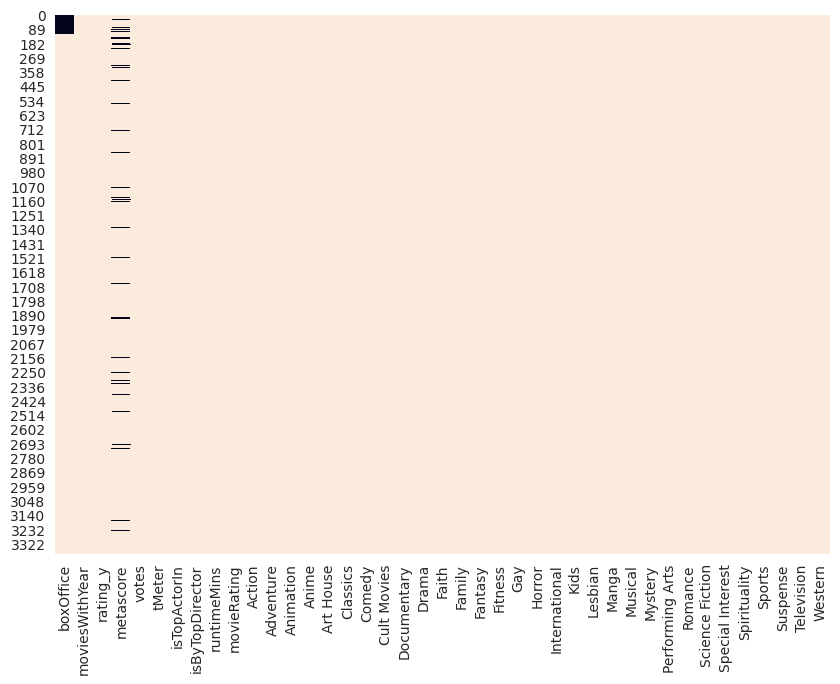

In [314]:
#Check missing values
plt.figure(figsize=(10,7))
sns.heatmap(~dataf.isnull(), cbar=False)
plt.show()

`metascore` appears to have a lot of missing values. The first few records in `boxOffice` also appear to be missing. We will not be using these features for most of our analysis, so we can afford to drop them.

In [315]:
dataf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3168 entries, 0 to 3387
Data columns (total 41 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   boxOffice         3053 non-null   object 
 1   moviesWithYear    3168 non-null   object 
 2   rating_y          3168 non-null   float64
 3   metascore         2987 non-null   float64
 4   votes             3168 non-null   object 
 5   tMeter            3168 non-null   object 
 6   isTopActorIn      3168 non-null   int64  
 7   isByTopDirector   3168 non-null   int64  
 8   runtimeMins       3168 non-null   object 
 9   movieRating       3168 non-null   object 
 10  Action            3168 non-null   int64  
 11  Adventure         3168 non-null   int64  
 12  Animation         3168 non-null   int64  
 13  Anime             3168 non-null   int64  
 14  Art House         3168 non-null   int64  
 15  Classics          3168 non-null   int64  
 16  Comedy            3168 non-null   int64  


We change the types of `boxOffice`, `votes`, `tMeter` and `runtimeMins`. We also conduct other edits and add a `year` attribute.

In [316]:
#Extract number from boxOffice attribute
dataf["boxOffice"] = dataf["boxOffice"].str.replace("$","").str.replace(",","")
#Convert boxOffice attribute to float type
dataf["boxOffice"] = dataf[~dataf["boxOffice"].isnull()]["boxOffice"].astype('int')

In [317]:
dataf["votes"] = dataf.votes.astype('int')
dataf["tMeter"] = dataf["tMeter"].astype('int')
dataf["runtimeMins"] = dataf["runtimeMins"].astype('int')

In [318]:
#Define a year attribute
dataf["year"] = dataf["moviesWithYear"].str.split().str[-1].str.extract('(\d{4})').astype('int')

In [319]:
#one-hot encode movieRating attribute
dataf = pd.concat([dataf.drop(columns="movieRating", axis= 1), pd.get_dummies(dataf["movieRating"])], axis=1)

In [320]:
dataf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3168 entries, 0 to 3387
Data columns (total 47 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   boxOffice         3053 non-null   float64
 1   moviesWithYear    3168 non-null   object 
 2   rating_y          3168 non-null   float64
 3   metascore         2987 non-null   float64
 4   votes             3168 non-null   int64  
 5   tMeter            3168 non-null   int64  
 6   isTopActorIn      3168 non-null   int64  
 7   isByTopDirector   3168 non-null   int64  
 8   runtimeMins       3168 non-null   int64  
 9   Action            3168 non-null   int64  
 10  Adventure         3168 non-null   int64  
 11  Animation         3168 non-null   int64  
 12  Anime             3168 non-null   int64  
 13  Art House         3168 non-null   int64  
 14  Classics          3168 non-null   int64  
 15  Comedy            3168 non-null   int64  
 16  Cult Movies       3168 non-null   int64  


<a id='4'></a>

## **Exploratory Data Analysis**

Now, we explore the available data set checking for correlation between attributes and plotting visualizations.

### Scores and Scores

To answer one of our first research questions about the correlation between the Tomatometer score of a movie and its rating from IMDb, we examine the correlation of these two variables.

In [321]:
dataf[["tMeter", "rating_y"]].corr()

,tMeter,rating_y
tMeter,1.000000,0.609875
rating_y,0.609875,1.000000


Firstly, we see quite significant positive correlation between these two attributes. This suggests that movies that are highly rated on Rotten Tomatoes may also be highly rated on IMDb. However, it doesn't say much about what the crowd and critics think about particular movies. We will attend to this subject under "Question Assessment".

We make a linear plot to see this relationship

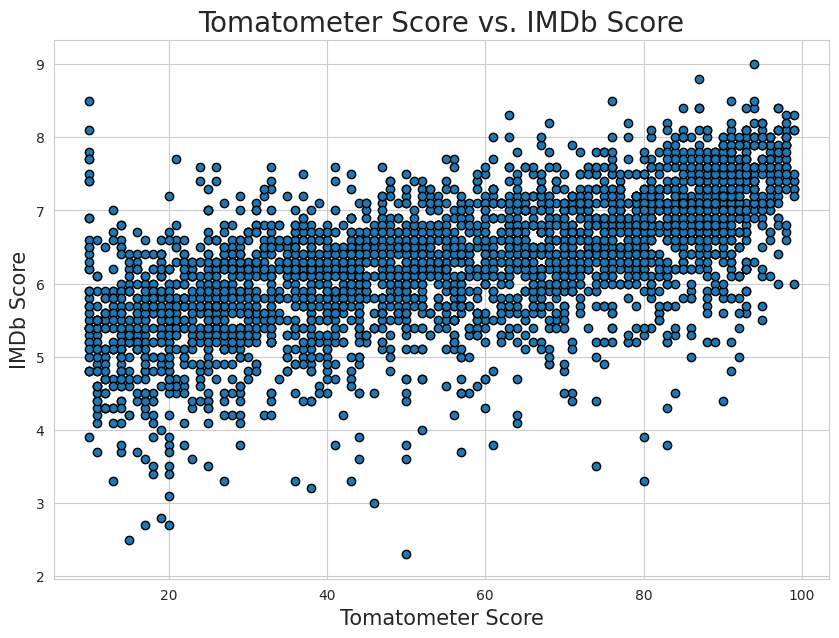

In [322]:
plt.figure(figsize=(10,7))
plt.scatter(dataf["tMeter"], dataf["rating_y"], edgecolor="black")
plt.grid(True)
plt.xlabel("Tomatometer Score", fontsize=15)
plt.ylabel("IMDb Score", fontsize=15)
plt.title("Tomatometer Score vs. IMDb Score", fontsize=20)
plt.show()

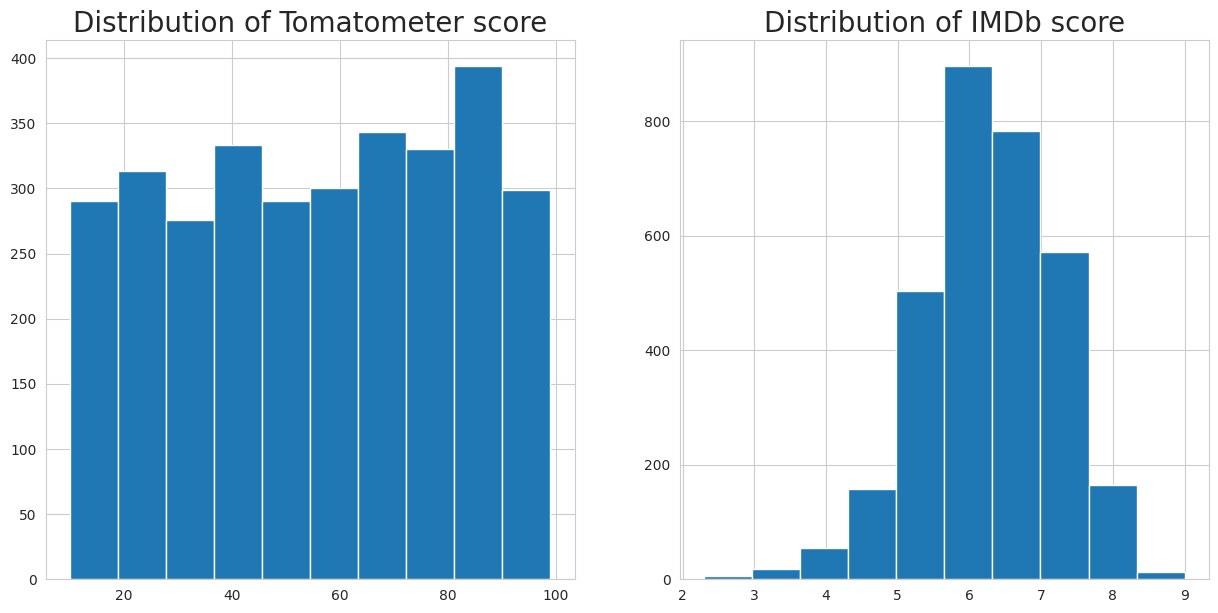

In [323]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.hist(dataf["tMeter"])
plt.title("Distribution of Tomatometer score", fontsize=20)
plt.grid(True)

plt.subplot(122)
plt.hist(dataf["rating_y"])
plt.title("Distribution of IMDb score", fontsize=20)
plt.grid(True)

plt.show()

It is quite curious that there is a linear relationship between the scores from the two platforms even though the scores from Rotten Tomatoes appear to be uniformly distributed, while those from IMDb look to be normally distributed.

The distribution of scores from Rotten Tomatoes show that the Tomatometer score is equally likely to be any number from 0 to 100, while the IMDb scores are distributed such that it is more likely for a movie to be mid-rated. This is also true for the larger data set.

When we examine the median scores from both platforms, we see that they are quite close. We have "normalized the two scores so that they are over 10.

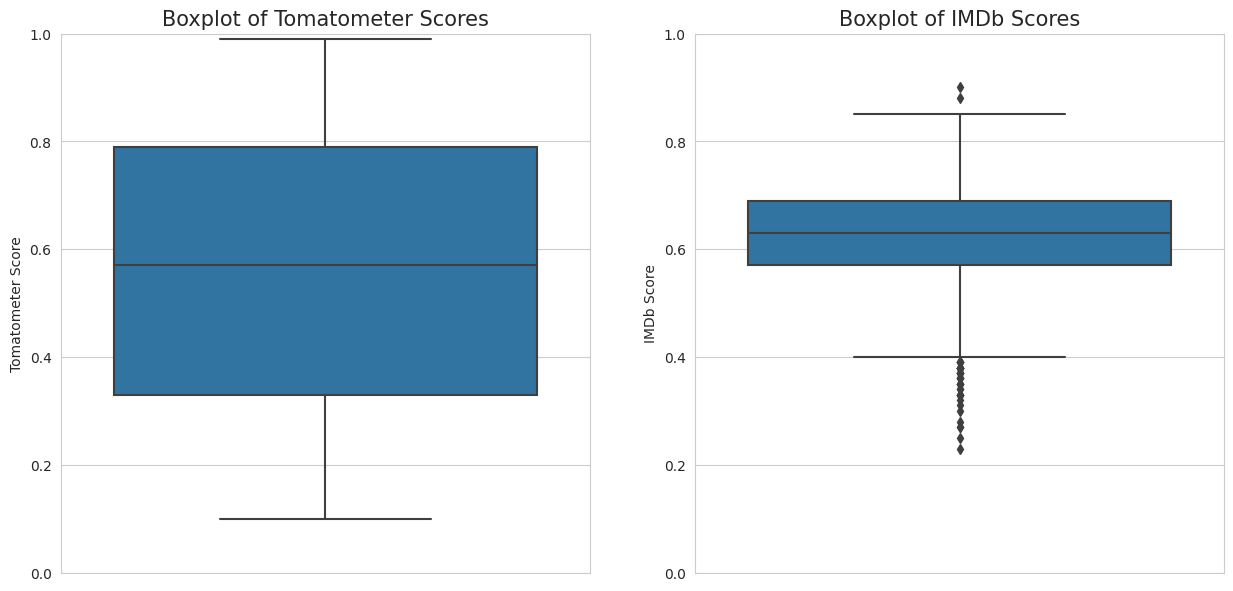

In [324]:
plt.figure(figsize=(15,7))

plt.subplot(121)
sns.boxplot(dataf.tMeter/100, orient='v')
plt.title("Boxplot of Tomatometer Scores", fontsize=15)
plt.ylabel("Tomatometer Score")
plt.ylim(0,1)

plt.subplot(122)
sns.boxplot(dataf.rating_y/10, orient='v')
plt.title("Boxplot of IMDb Scores", fontsize=15)
plt.ylabel("IMDb Score")
plt.ylim(0,1)

plt.show()

### The Older, The Better?

There does not appear to be a lot of difference in movie ratings over the years. This is reflected both in the IMDb scores and in the Tomatometer scores.

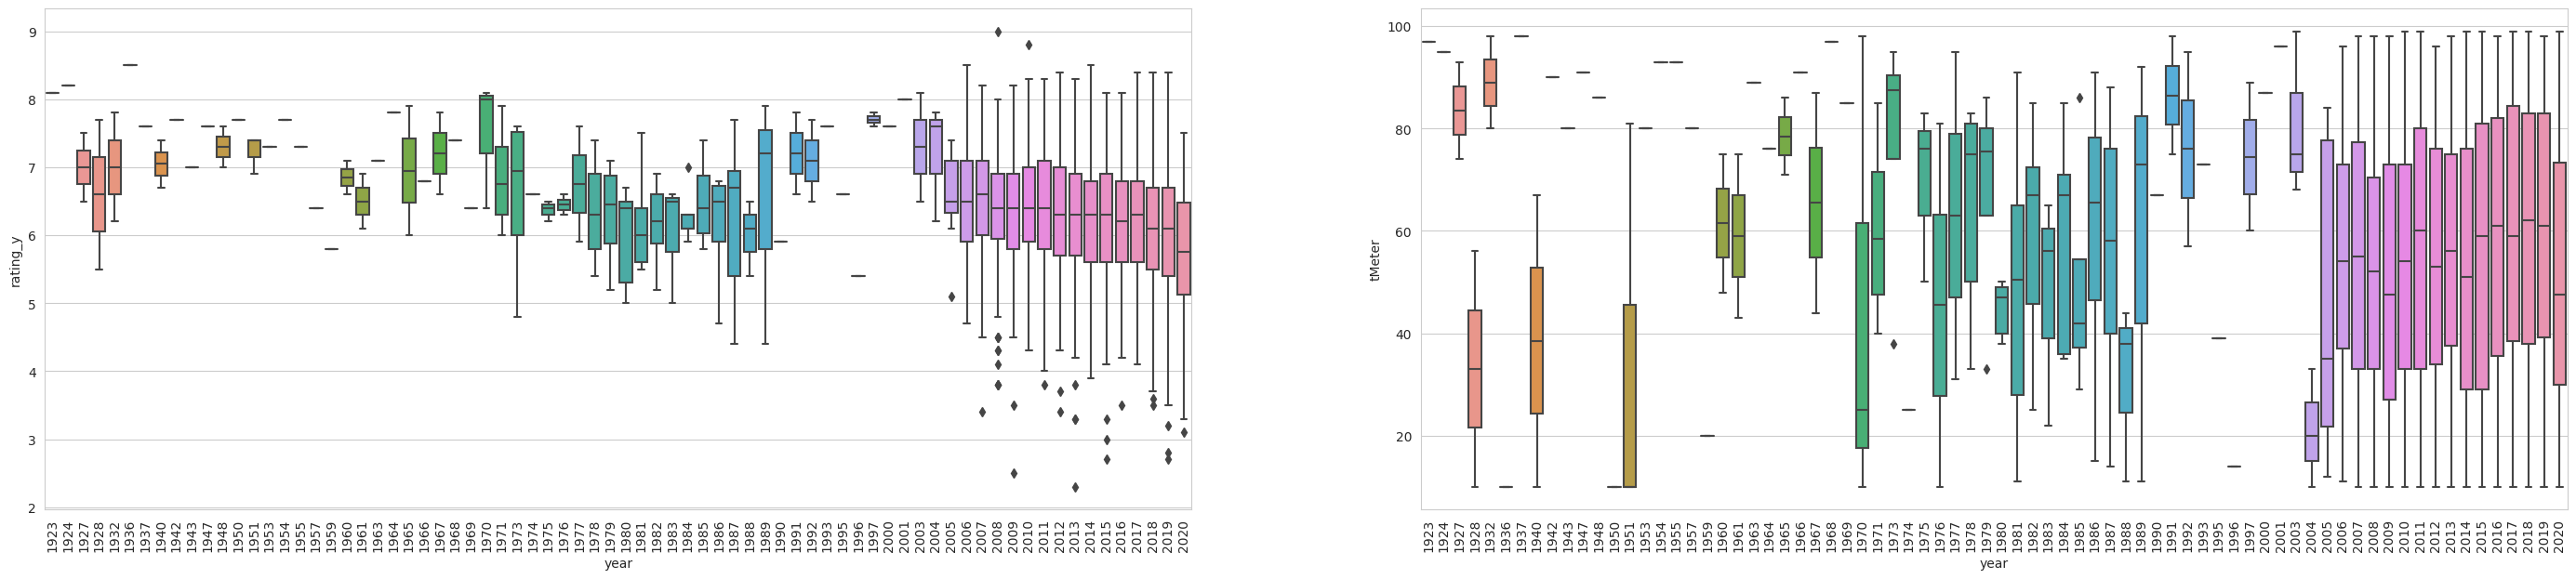

In [325]:
plt.figure(figsize=(35,7))

plt.subplot(121)
sns.boxplot(data=dataf, x="year", y="rating_y")
plt.xticks(rotation=90)

plt.subplot(122)
sns.boxplot(data=dataf, x="year", y="tMeter")
plt.xticks(rotation=90)

plt.show()


### Better with a Top Actor?

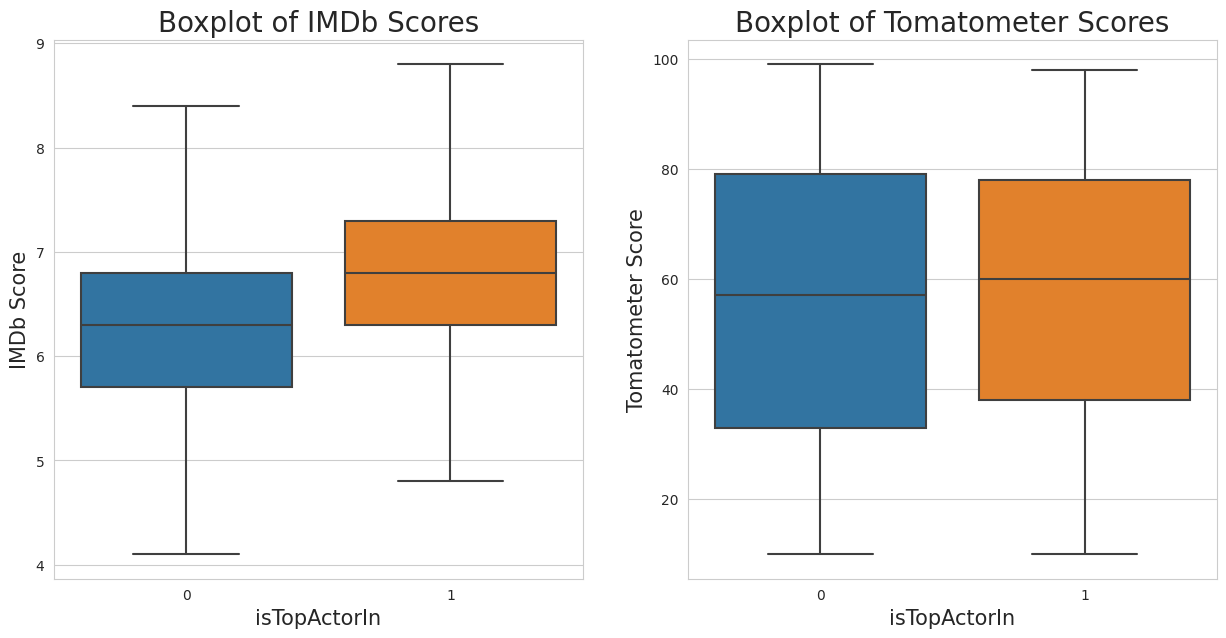

In [326]:
plt.figure(figsize=(15,7))

plt.subplot(121)
sns.boxplot(x='isTopActorIn', y='rating_y', data=dataf, orient='v', showfliers=False)
plt.ylabel('IMDb Score', fontsize=15)
plt.xlabel('isTopActorIn', fontsize=15)
plt.title('Boxplot of IMDb Scores', fontsize=20)

plt.subplot(122)
sns.boxplot(x='isTopActorIn', y='tMeter', data=dataf, orient='v', showfliers=False)
plt.ylabel('Tomatometer Score', fontsize=15)
plt.xlabel('isTopActorIn', fontsize=15)
plt.title('Boxplot of Tomatometer Scores', fontsize=20)
plt.show()

The median IMDb and Tomatometer score of a movie seems to be higher when a top actor is present in the movie. This is more true for the IMDb scores than it is for the Tomatometer score. Could it be the case that the crowd is more disposed to give a higher rating when a top actor is present?

We check with a t-test whether the difference in the means of the two groups of IMDb ratings, i.e. ratings with a top actor and without a top actor, are significantly different from each other.

In [327]:
from scipy.stats import ttest_ind, kruskal

In [328]:
ttest_ind(dataf[dataf["isTopActorIn"]==1].rating_y.values, dataf[dataf["isTopActorIn"]==0].rating_y.values)

Ttest_indResult(statistic=10.889935088713836, pvalue=3.874550133924456e-27)

We get a `p-value` significantly less than $\alpha = 0.05$, suggesting that we can reject the null hypothesis that the two means are equal. This means the crowd did, in fact, significantly rated movies with top actors higher than they did movies without top actors. Does this represent some bias?

Next, we use the Kruskal-Wallis test to check if the difference in means between the two groups of Tomatometer scores, with a top actor and without, are significantly different from each other.

In [329]:
kruskal(dataf[dataf["isTopActorIn"]==1].tMeter.values, dataf[dataf["isTopActorIn"]==0].tMeter.values)

KruskalResult(statistic=2.376293414132803, pvalue=0.12318952952200907)

With a `p-value` of $0.12 > 0.05$, we find that we fail to reject the null hypothesis that the means of these two groups are the same. It appears critics did not especially favour movies with top actors by rating them significantly higher. Though, overall, they did rate these movies higher, but the difference between scores for movies with and without top actors does not appear to be statistically significant.

### Better with a Top Director?

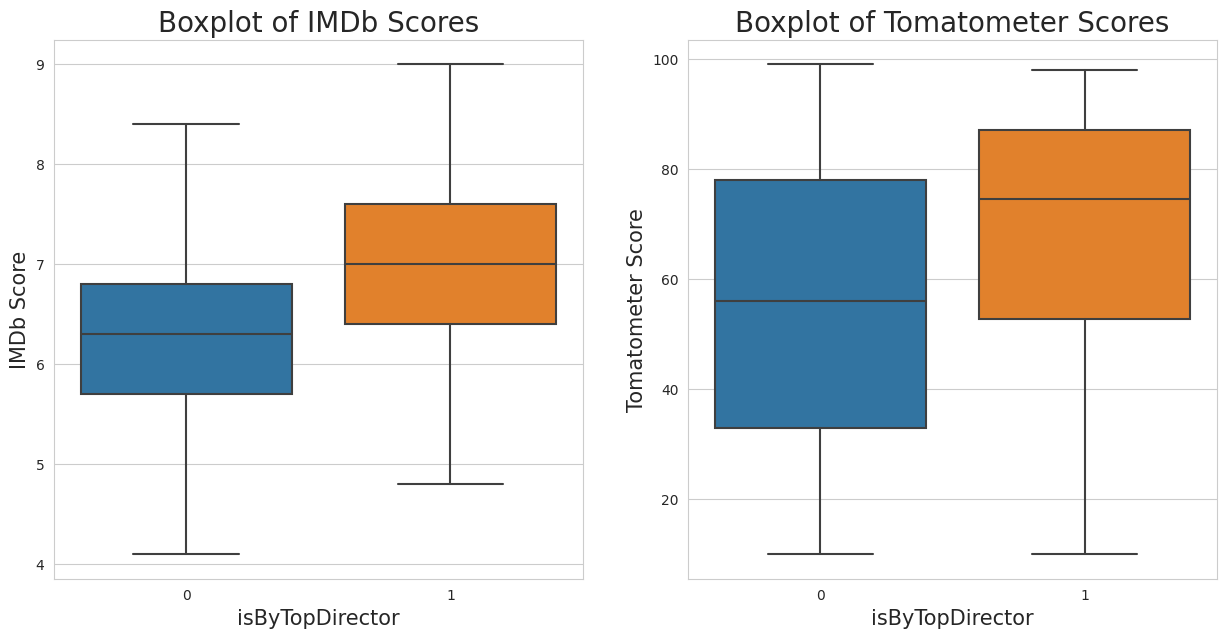

In [330]:
plt.figure(figsize=(15,7))

plt.subplot(121)
sns.boxplot(x='isByTopDirector', y='rating_y', data=dataf, orient='v', showfliers=False)
plt.ylabel('IMDb Score', fontsize=15)
plt.xlabel('isByTopDirector', fontsize=15)
plt.title('Boxplot of IMDb Scores', fontsize=20)

plt.subplot(122)
sns.boxplot(x='isByTopDirector', y='tMeter', data=dataf, orient='v', showfliers=False)
plt.ylabel('Tomatometer Score', fontsize=15)
plt.xlabel('isByTopDirector', fontsize=15)
plt.title('Boxplot of Tomatometer Scores', fontsize=20)

plt.show()

Whether a movie is by a top director appears to be a signifcant discriminative feature for both IMDb and Tomatometer scores. The median IMDb score of movies with a top director is significantly higher than that of movies without a top director. The same is true for the Tomatometer scores. This appears to be more true for the critics' assessment than it is for the crowd. This could mean that critics are more likely to rate a movie highly when it is directed by a top director. The crowd, on the other hand, does not seem to care much.

### More Money, More Ratings?

Next, we examine movie ratings against its box office value.

When we plot `boxOffice` against both the Tomatometer and the IMDb scores, we observe that the IMDb ratings seem to lean towards the right, suggesting that at higher box office values the movie ratings appear a little higher. Unlike the IMDb scores, the Tomatometer scores seem to be evenly distributed against box office values. For the Tomatometer scores, it seems the value of a movie's box office does not appear to have an effect on its ratings.

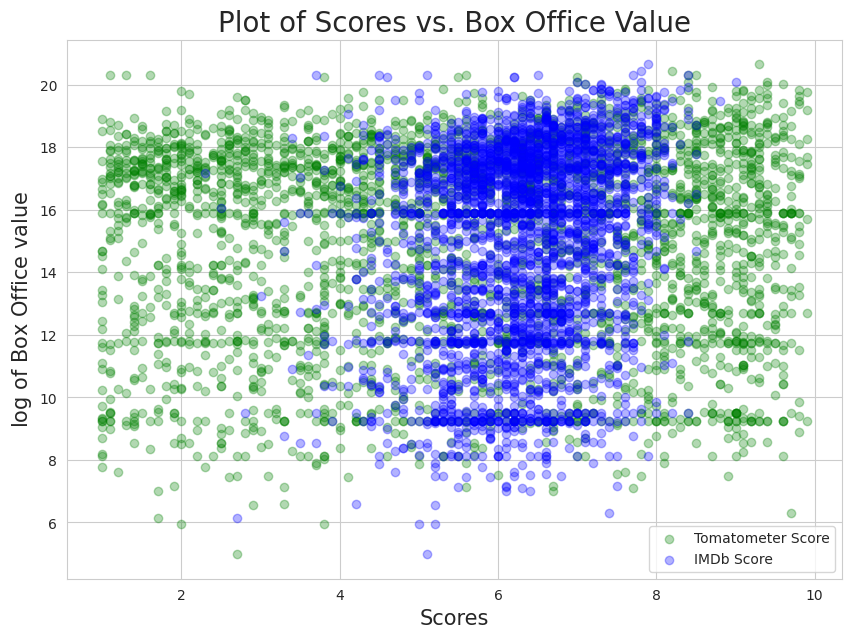

In [331]:
plt.figure(figsize=(10,7))
plt.scatter(dataf['tMeter']/10, np.log(dataf['boxOffice']+1), marker='o', color='green', alpha=0.3, label='Tomatometer Score')
plt.scatter(dataf['rating_y'], np.log(dataf['boxOffice']+1), marker='o', color='blue', alpha=0.3, label='IMDb Score')
plt.legend(loc='lower right')
plt.ylabel('$\log$ of Box Office value', fontsize=15)
plt.xlabel('Scores', fontsize=15)
plt.title('Plot of Scores vs. Box Office Value', fontsize=20)
plt.grid(True)
plt.show()

### Ratings and Ratings

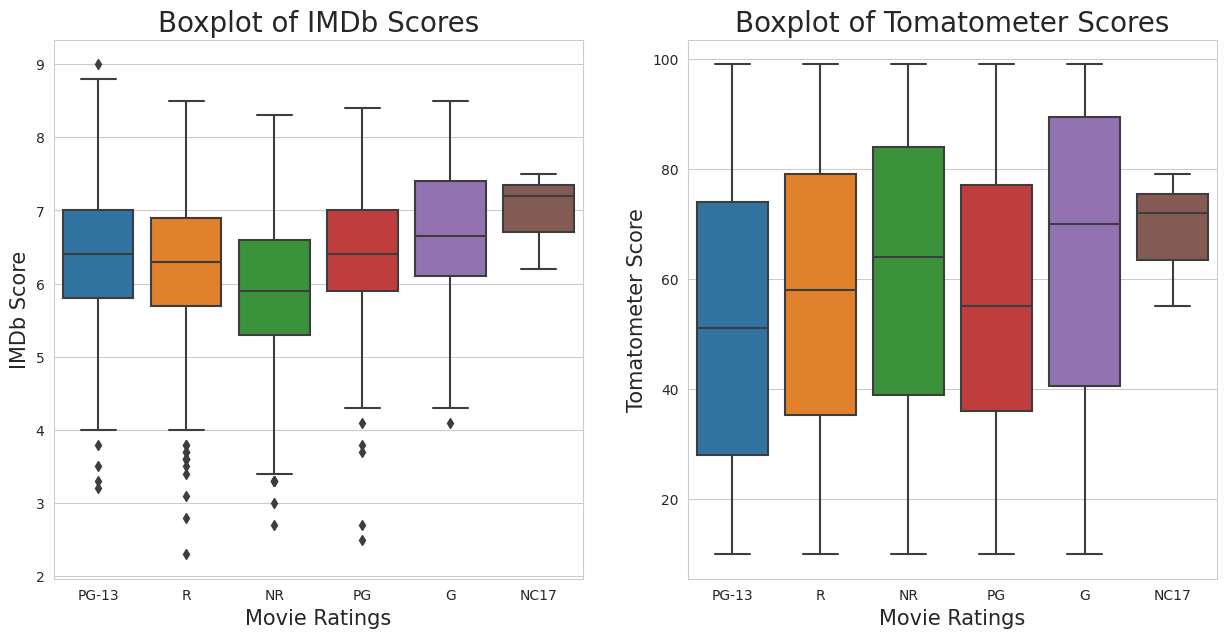

In [332]:
plt.figure(figsize=(15,7))

plt.subplot(121)
sns.boxplot(data=data, x='movieRating', y='rating_y')
plt.ylabel('IMDb Score', fontsize=15)
plt.xlabel('Movie Ratings', fontsize=15)
plt.title('Boxplot of IMDb Scores', fontsize=20)

plt.subplot(122)
sns.boxplot(data=data, x='movieRating', y=dataf['tMeter'])
plt.ylabel('Tomatometer Score', fontsize=15)
plt.xlabel('Movie Ratings', fontsize=15)
plt.title('Boxplot of Tomatometer Scores', fontsize=20)

plt.show()

It does appear movies rated NC-17 enjoy good reviews on both Rotten Tomatoes and IMDb. They have the highest scores. Movies rated G also appear to have quite good scores on both IMDb and Rotten Tomatoes. Unfortunately, however, this feature does not seem to be clearly discriminative.

<a id='5'></a>

## **Question Assessment**

A major component of our research question concerns itself with whether critics and crowd often agree on the ratings assigned to movies. We look into how frequently critics and crowd make similar decisions in our sample of movies and their ratings. We propose that if the Tomatometer score and the IMDb score are often equal or close to within a particular specified value, $x$, then there is good agreement between the crowd and the critics on movie ratings. How often will depend on its frequency and its closeness.

We define a function `returnBins` which returns the number of movies on which critics and crowd agree to within value `split`. In our sample set, we count the number of movies where the critics and crowd agree to within $x$. For example, if critics rate a movie 0.8 and the crowd rate the same movie 0.75, we say that both the critics and the crowd agree within 0.05 of a movie's rating. Prior to using `tMeter` and `rating_y`, which are the two ratings from both data sets, we scale the ratings using MinMaxScaler.

In [333]:
#make a copy of dataframe
datag = dataf.copy()

In [334]:
datag['tMeterScaled'] = (datag['tMeter'] - datag['tMeter'].min())/(datag['tMeter'].max() - datag['tMeter'].min())
datag['ratingyScaled'] = (datag['rating_y'] - datag['rating_y'].min())/(datag['rating_y'].max() - datag['rating_y'].min())

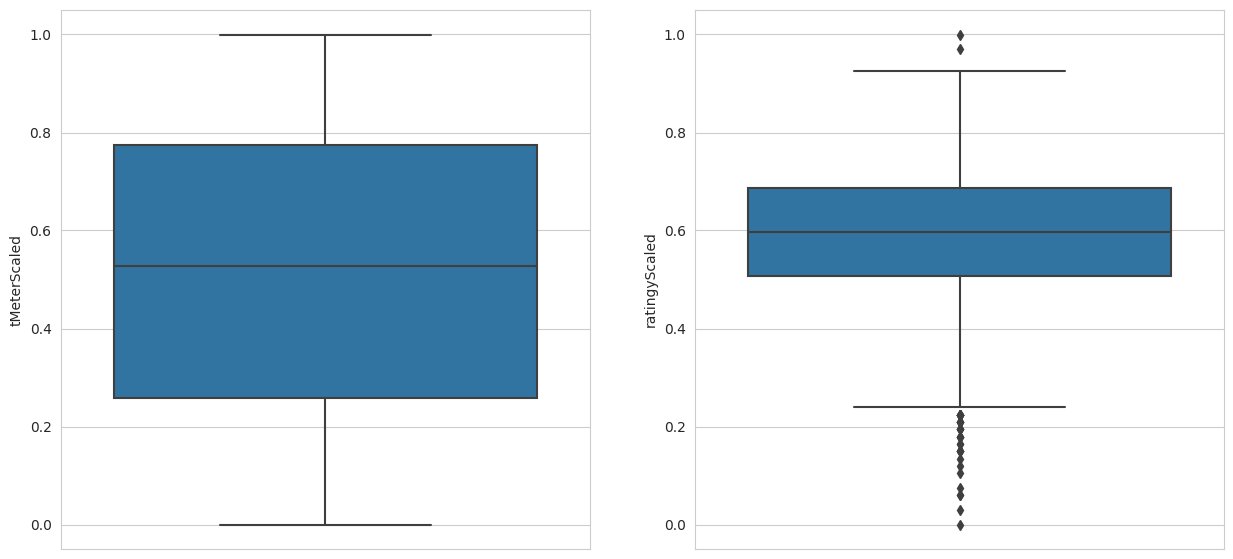

In [335]:
plt.figure(figsize=(15,7))

plt.subplot(121)
sns.boxplot(data=datag, y='tMeterScaled')

plt.subplot(122)
sns.boxplot(data=datag, y='ratingyScaled')

plt.show()

In [336]:
def returnBins(df, split=0.01):
  bins = pd.IntervalIndex.from_tuples([(-float('Inf'), -split), (-split, split), (split, float('Inf'))])
  return pd.cut((df['tMeterScaled'] - df['ratingyScaled']).values, bins=bins).value_counts() * 100/ \
          pd.cut((df['tMeterScaled'] - df['ratingyScaled']).values, bins=bins).value_counts().sum()

In the series below, we check the relative frequency of movies for which the IMDb score and Tomatometer Score are the same (to within a particular spread value of 0.01), the difference between both is higher than 0.01, and the difference between both is lower than 0.01. We divide the data into three bins, and in this case we have that for 3% of the movies in the data set, the difference in the ratings given by the crowd and critics is no more than 0.01. For 56% of the data, the ratings given by critics is lower than those given by the crowd by more than 0.01, while for 40% of the data the rating given by critics is higher than that provided by the crowd by more than 0.01.

In using the data this way, we assume that the Tomatometer and IMDb Scores are provided on a linear scale whereby higher ratings correspond to better movie reviews. This is largely true. On Rotten Tomatoes, Tomatometer Scores are provided in addition to average ratings. Tomatometer Scores are stated over 100%, while average ratings by critics are stated over 10. Average ratings on IMDb provided by the crowd are also stated over 10. In this assessment, we used Tomatometer Scores stated over 100 and IMDb scores stated over 10. We believe the average critic rating quoted over 10 on Rotten Tomatoes correlates well with the Tomatometer Score (which we consider the most defining feature from the review website). In Appendix A, we examine a sample of data from Rotten Tomatoes and show that a strong enough correlation exists between average critic ratings and Tomatometer Score to warrant subsituting the latter for the former.

In [337]:
returnBins(datag, 0.01)

(-inf, -0.01]    56.944444
(-0.01, 0.01]     3.061869
(0.01, inf]      39.993687
dtype: float64

When we plot this on a graph for different

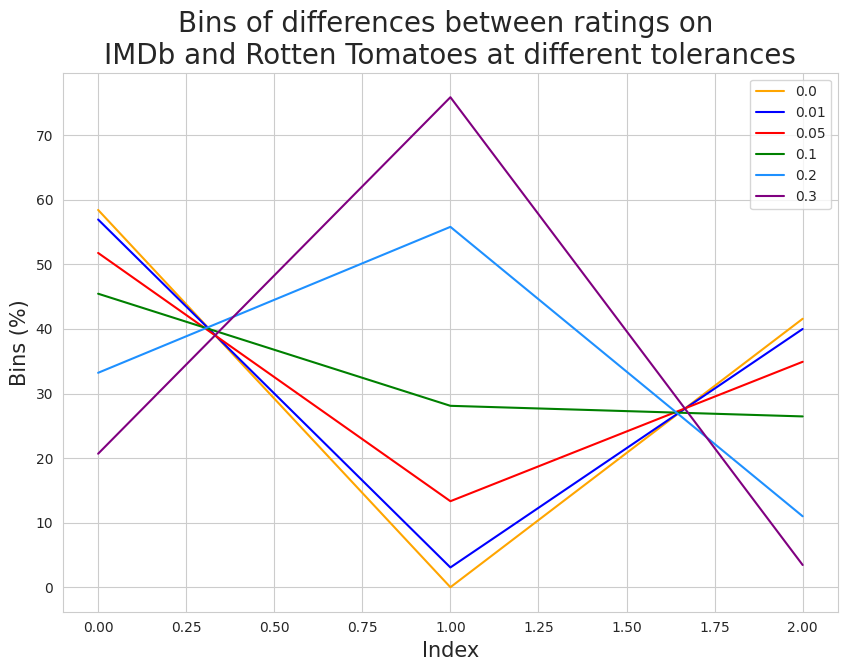

In [396]:
plt.figure(figsize=(10,7))
for i, color in zip([0.0, 0.01, 0.05, 0.1, 0.2, 0.3], 
             ["orange", "blue", "red", "green", "dodgerblue", "purple"]):
  plt.plot(returnBins(datag, i).values, color=color, label=i)
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('Index', fontsize=15)
plt.ylabel('Bins (%)', fontsize=15)
plt.title('Bins of differences between ratings on \nIMDb and Rotten Tomatoes at different tolerances', fontsize=20)
plt.show()

It appears when we use a small spread value, there are very few movies on which critics and crowd agree. So, there are only few movies on which critics and crowd agree to within 0. But as we increase limit value, the number of movies on which both agree increases. At a value of 0.2, it appears critics and crowd agree more than they disagree on movie ratings. Spread appears to play a critical role here, the higher the spread we are willing to tolerate, the more agreement we see in the assessment provided by critics and crowd. If we allow an error of $\pm$0.3 in the provided ratings, we are inclined to accept that critics and crowd agree more than they disagree.

However, for a distribution of values from 0 to 1 where 1 means a movie has maximum rating and 0 means the lowest rating, we are inclined to not tolerate a spread of 0.3 as that is quite large. A spread of 0.3 puts a movie with a rating of 0.67 in the same group as a movie with a rating of 0.96. This clearly is not our objective. If we limit the spread to 0.1, so that movies with ratings of 0.67 and 0.77 are in the same category, we find that there are very few movies on which the critics and the crowd are in agreement. In this case, they are only in agreement on 28% of movies in the data set. This shows quite a wide gap between the opinions provided by critics and those provided by the crowd. 

Next, we examine this same scenario by year. How often do critics and crowd agree year after year? We restrict the years under review to 2004 to 2020, because we have a large enough data set for these years only.

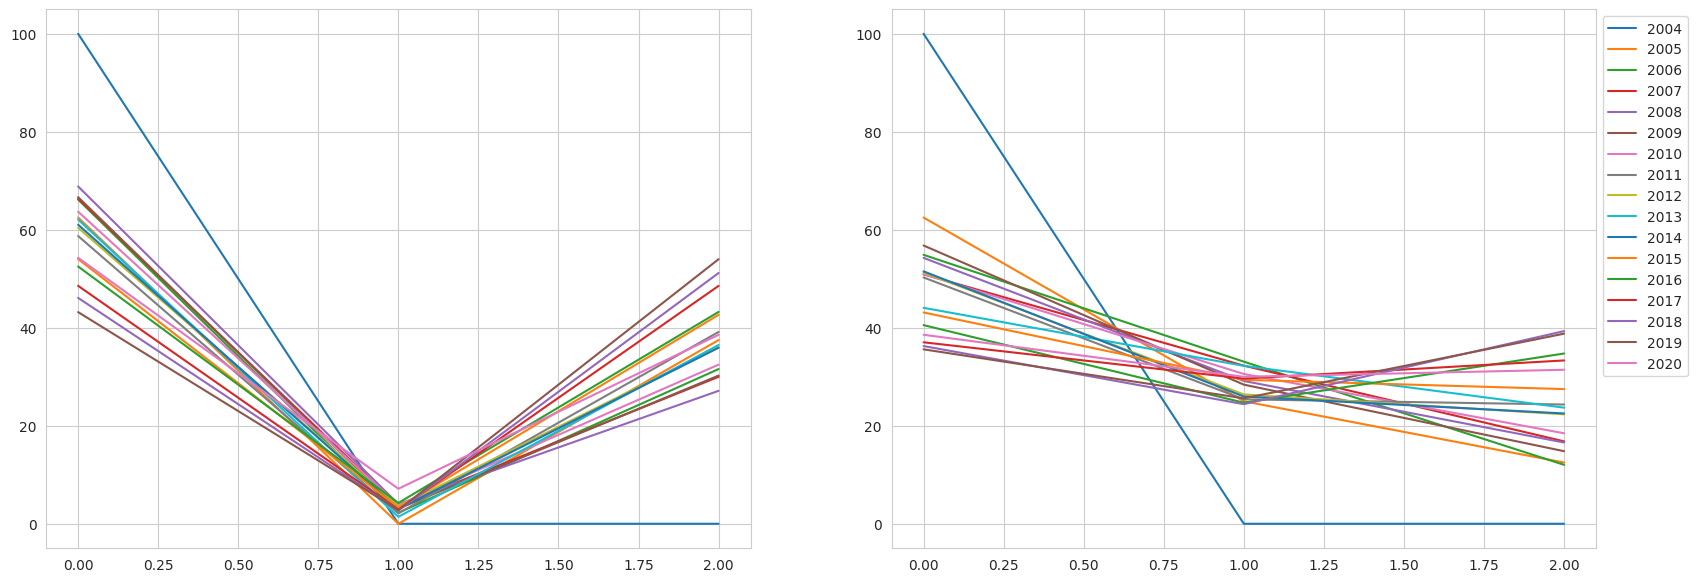

In [339]:
plt.figure(figsize=(20,7))

plt.subplot(121)
for year in range(2004,2021):
  plt.plot(returnBins(datag.groupby('year').get_group(year)).values, label=str(year))
plt.grid(True)


plt.subplot(122)
for year in range(2004,2021):
  plt.plot(returnBins(datag.groupby('year').get_group(year), 0.1).values, label=str(year))
plt.legend(bbox_to_anchor=(1.14,1), loc='upper right')
plt.grid(True)

plt.show()

When we use the default spread of 0.01 in the difference in ratings, we see that the frequency of agreement over the years is actually quite low. Increasing the spread to 0.1 produces a relative frequency plot which, again, shows little to no agreement in the opinions of critics and crowd. This means consensus is very low.

In [340]:
d, e, f = {}, {}, {}
for year in datag.groupby('year').groups.keys():
  d[year]=(returnBins(datag.groupby('year').get_group(year), 0.1).values[1])
  e[year]=(returnBins(datag.groupby('year').get_group(year), 0.1).values[0])
  f[year]=(returnBins(datag.groupby('year').get_group(year), 0.1).values[2])

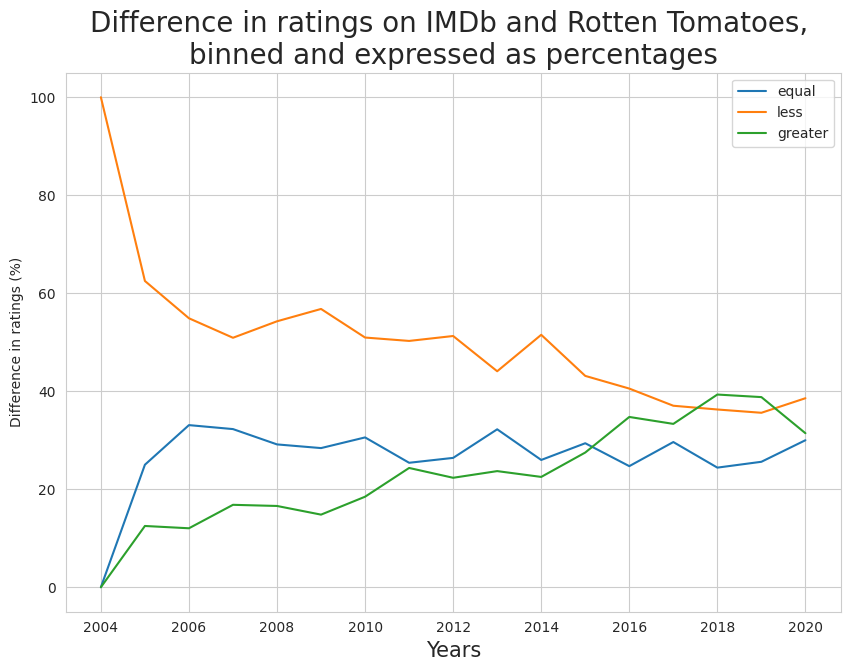

In [341]:
plt.figure(figsize=(10,7))
pd.Series(d).loc['2004':].plot(label='equal')
pd.Series(e).loc['2004':].plot(label='less')
pd.Series(f).loc['2004':].plot(label='greater')
plt.xlabel('Years', fontsize=15)
plt.ylabel('Difference in ratings (%)')
plt.title('Difference in ratings on IMDb and Rotten Tomatoes, \nbinned and expressed as percentages', fontsize=20)
plt.grid(True)
plt.legend()
plt.show()

It appears there is no consensus between critics and crowd. Though this is dependent on the spread, there is just enough tolerance we can allow for in adjusting this spread. A spread of 0.1 seems good enough to base our analysis on. The plot above shows that over the years, it is less likely that the movie ratings provided by critics and crowd are within 0.1 of each other. If anything, it is more probable that Tomatometer Score of a movie is lower than its IMDb score. **In effect, while critics appear to be penalizing certain movies by providing them lower scores, the crowd seem to give these same movies a higher rating**.

Therefore, though the ratings provided by the crowd and by critics have a high correlation, it does appear that they are significantly different.

<a id='6'></a>

## **Model Building**

In this section, we build a model which predicts the IMDb score of a movie given all its Rotten Tomatoes attributes. We propose that since there is significant correlation between the IMDb score of a movie and its Rotten Tomatoes score, we should be able to obtain one from the other. If there is indeed a linear relationship between these two variables, the coefficients relating one to the other will not be zero, and should have p-values show that the coefficients are statistical significance.

Even if critics do not score a movie like the crowd does, we should be able to go from a critic's mind to the crowd's. We believe the results of the model should show what the crowd is likely to score a movie given the details we know about the movie from the critic's perspective.

In [342]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [343]:
#We drop features from the IMDb data set, while keeping features from the Rotten Tomatoes data set.
#We also drop NA's.
dataf.drop(columns=["moviesWithYear", "metascore", "votes"], axis=1, inplace=True)

We fill the missing values under `boxOffice` with the median values

In [344]:
#Extract the most important features
dataf["boxOffice"] = dataf.boxOffice.fillna(value=dataf.boxOffice.median())

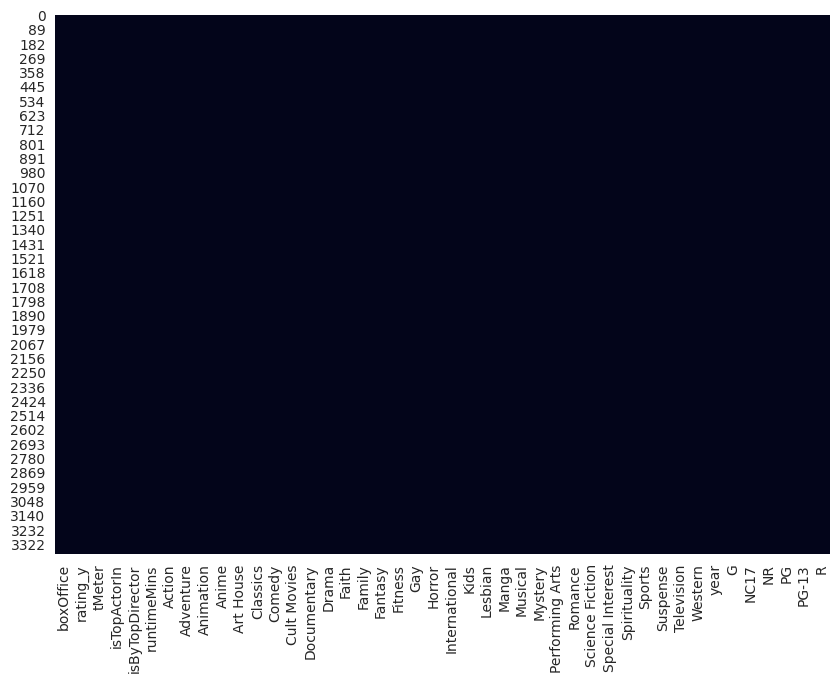

In [345]:
#Check if there are any null values
plt.figure(figsize=(10,7))
sns.heatmap(dataf.isnull(), cbar=False)
plt.show()

We find that there are no longer any null values

In [346]:
dataf.head()

,boxOffice,rating_y,tMeter,isTopActorIn,isByTopDirector,runtimeMins,Action,Adventure,Animation,Anime,Art House,Classics,Comedy,Cult Movies,Documentary,Drama,Faith,Family,Fantasy,Fitness,Gay,Horror,International,Kids,Lesbian,Manga,Musical,Mystery,Performing Arts,Romance,Science Fiction,Special Interest,Spirituality,Sports,Suspense,Television,Western,year,G,NC17,NR,PG,PG-13,R
0,7916886.0,7.1,79,1,0,101,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020,0,0,0,0,1,0
1,7916886.0,6.7,81,0,0,125,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,2020,0,0,0,0,0,1
2,7916886.0,3.3,27,0,0,82,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,2020,0,0,1,0,0,0
3,7916886.0,5.7,50,0,0,98,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020,0,0,1,0,0,0
4,7916886.0,6.0,99,0,0,99,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020,0,0,1,0,0,0


Using all the predictors available from Rotten Tomatoes, we predict the IMDb score of a movie. This is a task attempting to go from one score to the other, given the relationship between both. As an added task, in Appendix B, we examine another intuitive problem which predicts the Tomatometer Score of a movie using **only** its predictors from Rotten Tomatoes.

In [347]:
X = dataf.drop(columns="rating_y")
y = dataf['rating_y']

In [348]:
#Divide data set into training and test sets. We reserve 30% of the data for testing
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=42)

In the subsequent cells, we fit different models using this data set. Firstly, we fit a linear regression model to get general perspective on the results to expect. Thereafter we built other regressors using Random Forest, Gradient Boosting and then AdaBoost. In the end, we compare the different metrics produced by the different models. Our metric of concern is the root mean squared error (RMSE).

We identify the most important features

In [349]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor(n_estimators=10)
model.fit(X, y)
sorted_feature_importances_ = sorted(zip(model.feature_importances_, X.columns))

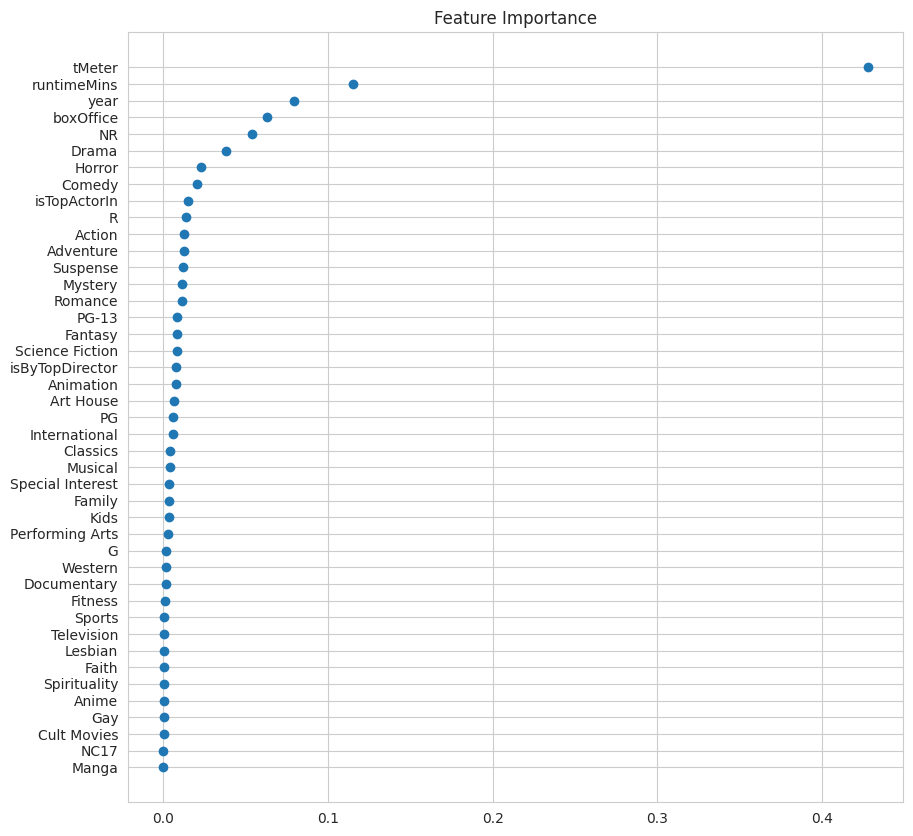

In [350]:
xx = [i[0] for i in sorted_feature_importances_]
yy = [i[1] for i in sorted_feature_importances_]

sns.set_style('whitegrid')
plt.figure(figsize=(10,10))
plt.scatter(xx, yy)
plt.title("Feature Importance")
plt.show()

The most important feature appears to be `tMeter`, followed by `runtimeMins`. Some of the movie categories do not appear very important.

### Linear Regression

In [351]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold, cross_val_score


In [352]:
#Create and fit model
lr = LinearRegression()
lr.fit(X_tr, y_tr)

y_pred_tr = lr.predict(X_tr)
y_pred_te = lr.predict(X_te)

In [353]:
from IPython.display import display, Markdown
print("-------------------------------------------------")
print("\t       Training Set\tTest set")
print("-------------------------------------------------")
print("MSE       |{:^20}{:^12}".format(round(mean_squared_error(y_tr, y_pred_tr),3),
                                 round(mean_squared_error(y_te, y_pred_te),3))) #MSE
print("RMSE      |{:^20}{:^12}".format(round(mean_squared_error(y_tr, y_pred_tr) ** (1/2),3),
                                 round(mean_squared_error(y_te, y_pred_te) ** (1/2),3))) #RMSE
print("R^2 Score |{:^20}{:^12}".format(round(r2_score(y_tr, y_pred_tr),3),
                                       round(r2_score(y_te, y_pred_te),3))) #R^2 Score

-------------------------------------------------
	       Training Set	Test set
-------------------------------------------------
MSE       |       0.373           0.376    
RMSE      |       0.611           0.613    
R^2 Score |       0.551           0.555    


The model reports a RMSE of 0.611 which seems reasonably good. This means that for each result we get in the prediction, on average the predicted IMDb rating is off by about 0.611. For a rating scale between 1 and 10, this appears quite good.

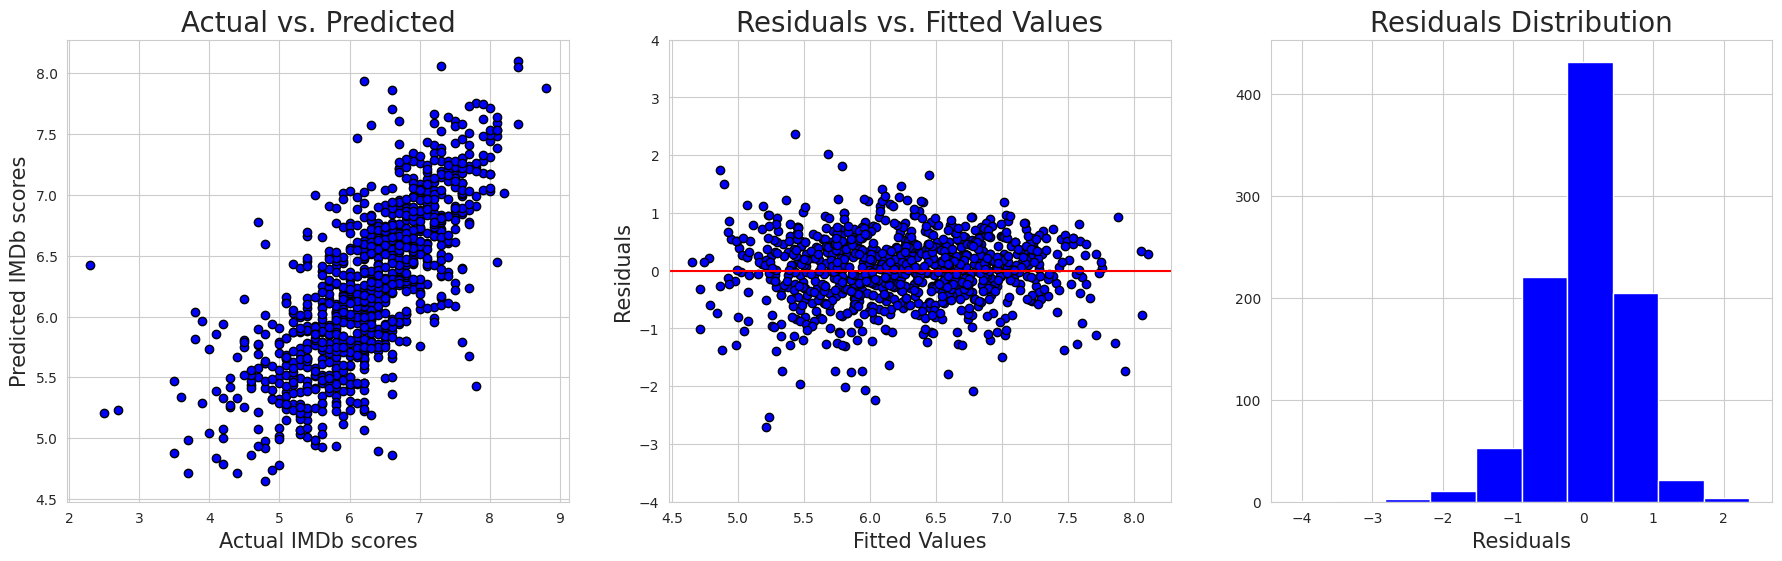

In [354]:
plt.figure(figsize=(22,6))

plt.subplot(131)
plt.plot(y_te, y_pred_te, 'bo', markeredgecolor='black')
plt.xlabel("Actual IMDb scores", fontsize=15)
plt.ylabel("Predicted IMDb scores", fontsize=15)
plt.title("Actual vs. Predicted", fontsize=20)

plt.subplot(132) #make residuals plot
resids = y_te - y_pred_te
plt.plot(y_pred_te, resids, 'bo', markeredgecolor='black')
plt.xlabel("Fitted Values", fontsize=15)
plt.ylabel("Residuals", fontsize=15)
plt.title("Residuals vs. Fitted Values", fontsize=20)
plt.ylim(-4,4)
plt.axhline(y=0, color="red")

plt.subplot(133)
plt.hist(resids, color='blue')
plt.xlabel("Residuals", fontsize=15)
plt.title("Residuals Distribution", fontsize=20)

plt.show()

In a plot of the actual vs. predicted values, we see that most of the datapoints lie on a straightline. This shows good correlation between our predictions and the actual IMDb scores. The residuals vs. fitted plot shows that the residuals do not have any unusual distribution. They appear equally distributed across the the y=0 line. The final plot confirms that the residuals are normally distributed. All these suggest that our model looks good.

We perform cross validation with the `lr` model to see its effect on the MSE score. We conduct a 20-fold cross-validaton using the entire data set.

In [355]:
#Cross-validation
crv_scores = cross_val_score(lr, X, y, cv=20, scoring="neg_mean_squared_error")
crv_scores

array([-0.6296028 , -0.39644671, -0.36565882, -0.55352221, -0.28982422,
       -0.3377327 , -0.38582662, -0.35401099, -0.36986055, -0.43544356,
       -0.44070969, -0.39269883, -0.44307572, -0.26232298, -0.29771661,
       -0.4045185 , -0.29125414, -0.36604885, -0.32823068, -0.32552181])

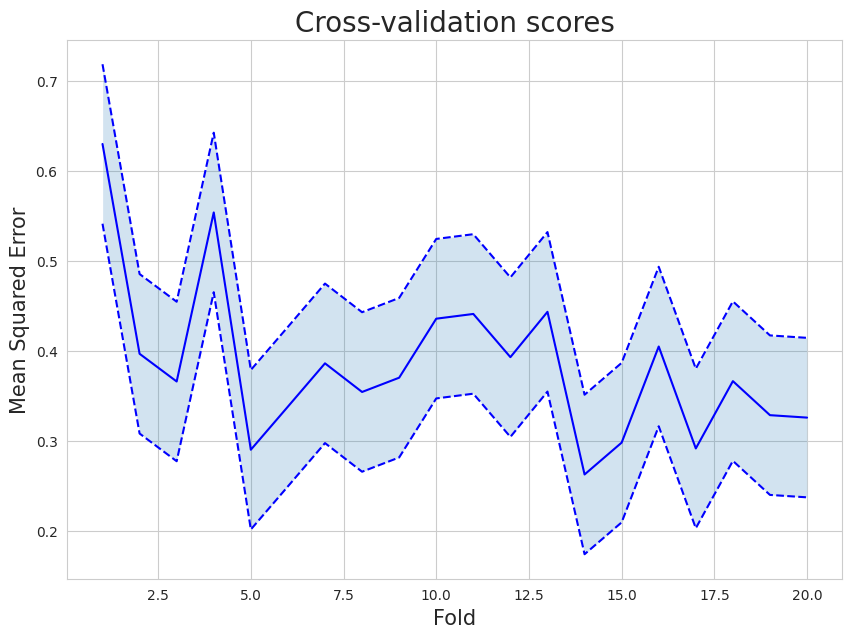

In [356]:
plt.figure(figsize=(10,7))
xax = np.arange(len(crv_scores)) + 1
mse = -crv_scores
std = np.std(-crv_scores, ddof=1)
plt.plot(xax, mse, 'b')
plt.plot(xax, mse + std, 'b--')
plt.plot(xax, mse - std, 'b--')
plt.fill_between(xax, mse + std, mse - std, alpha=0.2)
plt.title("Cross-validation scores", fontsize=20)
plt.xlabel("Fold", fontsize=15)
plt.ylabel("Mean Squared Error", fontsize=15)
plt.grid(True)
plt.show()

The plot shows that the mean squared error settles around 0.3, which is close to what we obtained on our test set.
**We attempted to use regularization, but found that using any of lasso or ridge regression did not seem to improve the model.**

### Boosting Algorithms
The two main boosting algorithms are Adaptive Boosting and Gradient Boosting. XGBoot, LightGBM and CatBoost are basically different implementations of Gradient Boosting. 
In our project purpose we will do 2 types of boosting :-

 AdaBoost
 
CatBoost

For reading purpose please use this https://randlow.github.io/posts/machine-learning/boosting-explain/

### AdaBoost

Here, we implement AdaBoost regressor

In [358]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

First, we fit the AdaBoost regressor using default parameters and a `max_depth` of 100 with the DecisionTree Regressor.

In [359]:
ada_regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10),
                             n_estimators=200,
                             random_state=42)
ada_regr.fit(X_tr, y_tr)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=10,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
                 

In [360]:
y_pred_tr = ada_regr.predict(X_tr)
y_pred_te = ada_regr.predict(X_te)

In [361]:
#Metrics for test set
mean_squared_error(y_te, y_pred_te)
print("MSE: ", mean_squared_error(y_te, y_pred_te)) #MSE
print("RMSE: ", mean_squared_error(y_te, y_pred_te) ** (1/2)) #RMSE
print("R^2 Score: ", r2_score(y_te, y_pred_te)) #R^2 Score

MSE:  0.3777704089958478
RMSE:  0.6146303026989866
R^2 Score:  0.5534351115875834


This produces a MSE of 0.378 on the test set.

Next, we use `RandomizedSearchCV` and attempt to find the best parameters for the model.

In [362]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform

In [363]:
params_ = {'n_estimators': [50, 100, 150, 200],
           'learning_rate': [0.01, 0.05, 0.1, 0.3, 1],
           'loss': ['linear', 'square', 'exponential']}

rscv = RandomizedSearchCV(ada_regr, 
                          param_distributions=params_, 
                          cv=3, 
                          n_iter=10,
                          random_state=42)

rscv.fit(X_tr, y_tr)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                                                    criterion='mse',
                                                                                    max_depth=10,
                                                                                    max_features=None,
                                                                                    max_leaf_nodes=None,
                                                                                    min_impurity_decrease=0.0,
                                                                                    min_impurity_split=None,
                                                                                    min_samples_leaf=1,
                                                                                    min_samples_split=2,
                       

We find that using an exponential loss function to update the weights after each boosting iteration works best.

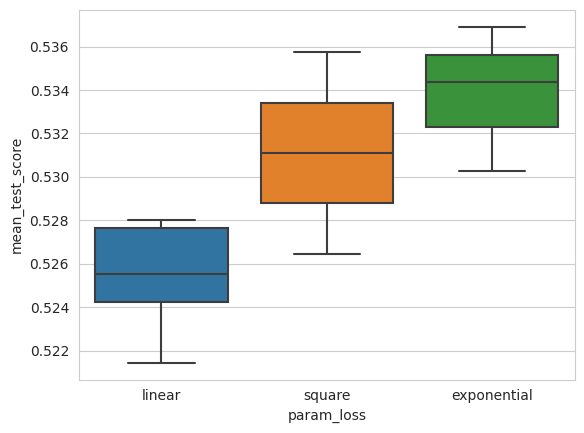

In [364]:
rscvDf = pd.DataFrame(rscv.cv_results_)[['param_loss', 'mean_test_score', 'std_test_score']]
sns.boxplot(data=rscvDf, x='param_loss', y='mean_test_score')
plt.show()

In [365]:
rscv.best_params_

{'learning_rate': 1, 'loss': 'exponential', 'n_estimators': 100}

In [366]:
#Metrics for test set
y_pred_te = rscv.best_estimator_.predict(X_te)
print("MSE: ", mean_squared_error(y_te, y_pred_te)) #MSE
print("RMSE: ", mean_squared_error(y_te, y_pred_te) ** (1/2)) #RMSE
print("R^2 Score: ", r2_score(y_te, y_pred_te)) #R^2 Score

MSE:  0.3792833637602573
RMSE:  0.6158598572404742
R^2 Score:  0.551646637796485


By using a combination of a linear loss function, a learning rate of 1 and number of estimators of 50, we are unable to improve the MSE.

### Gradient Boosting: CatBoost

In [367]:
!pip install catboost

In [368]:
from catboost import CatBoostRegressor, cv, Pool
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform

In [369]:
dataf_catboost = dataf.copy()

In [370]:
#preparing data for split
#specify feature variables
X=dataf_catboost.drop(columns=['rating_y'])
X=X.fillna(-1)
print(X.columns)
categorical_features_indices = np.where(X.dtypes != np.float)[0]
# specify target variable
y=dataf_catboost['rating_y']
#test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Index(['boxOffice', 'tMeter', 'isTopActorIn', 'isByTopDirector', 'runtimeMins',
       'Action', 'Adventure', 'Animation', 'Anime', 'Art House', 'Classics',
       'Comedy', 'Cult Movies', 'Documentary', 'Drama', 'Faith', 'Family',
       'Fantasy', 'Fitness', 'Gay', 'Horror', 'International', 'Kids',
       'Lesbian', 'Manga', 'Musical', 'Mystery', 'Performing Arts', 'Romance',
       'Science Fiction', 'Special Interest', 'Spirituality', 'Sports',
       'Suspense', 'Television', 'Western', 'year', 'G', 'NC17', 'NR', 'PG',
       'PG-13', 'R'],
      dtype='object')


In [371]:
# indices of categorical features
categorical_features_indices

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42])

In [372]:
# specify details for catboost regressor
model=CatBoostRegressor(iterations=100, 
                        depth=10, 
                        learning_rate=0.1, 
                        loss_function='RMSE',
                        random_state=42)


# fit the model
model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8746235	test: 0.9013487	best: 0.9013487 (0)	total: 58ms	remaining: 5.75s
1:	learn: 0.8467542	test: 0.8728210	best: 0.8728210 (1)	total: 62.7ms	remaining: 3.07s
2:	learn: 0.8225943	test: 0.8477742	best: 0.8477742 (2)	total: 106ms	remaining: 3.43s
3:	learn: 0.8006986	test: 0.8251962	best: 0.8251962 (3)	total: 168ms	remaining: 4.03s
4:	learn: 0.7802455	test: 0.8044517	best: 0.8044517 (4)	total: 205ms	remaining: 3.89s
5:	learn: 0.7635452	test: 0.7874884	best: 0.7874884 (5)	total: 243ms	remaining: 3.81s
6:	learn: 0.7473732	test: 0.7748958	best: 0.7748958 (6)	total: 269ms	remaining: 3.57s
7:	learn: 0.7354387	test: 0.7635391	best: 0.7635391 (7)	total: 325ms	remaining: 3.74s
8:	learn: 0.7224474	test: 0.7532242	best: 0.7532242 (8)	total: 356ms	remaining: 3.6s
9:	learn: 0.7102551	test: 0.7424338	best: 0.7424338 (9)	total: 379ms	remaining: 3.41s
10:	learn: 0.7014224	test: 0.7354903	best: 0.7354903 (10)	total: 401ms	remaining: 3.24s
11:	learn: 0.6921178	test: 0.7278334	best: 0.7278334 

In [373]:
y_predict_train = model.predict(X_train)
y_predict_test = model.predict(X_test)

In [374]:
# print out the MSE,RMSE,R^2 data
mean_squared_error(y_test, y_predict_test)
print("MSE: ", mean_squared_error(y_test, y_predict_test)) #MSE
print("RMSE: ", mean_squared_error(y_test, y_predict_test) ** (1/2)) #RMSE
print("R^2 Score: ", r2_score(y_test, y_predict_test)) #R^2 Score

MSE:  0.4174108236057973
RMSE:  0.646073388715088
R^2 Score:  0.5219058170491018


This produces a MSE of 0.417 on the test set.

Which are the most Important feature ? 
Let's start by giving them score

In [375]:
feature_score = pd.DataFrame(list(zip(X.dtypes.index, model.get_feature_importance(Pool(X, label=y, cat_features=categorical_features_indices)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

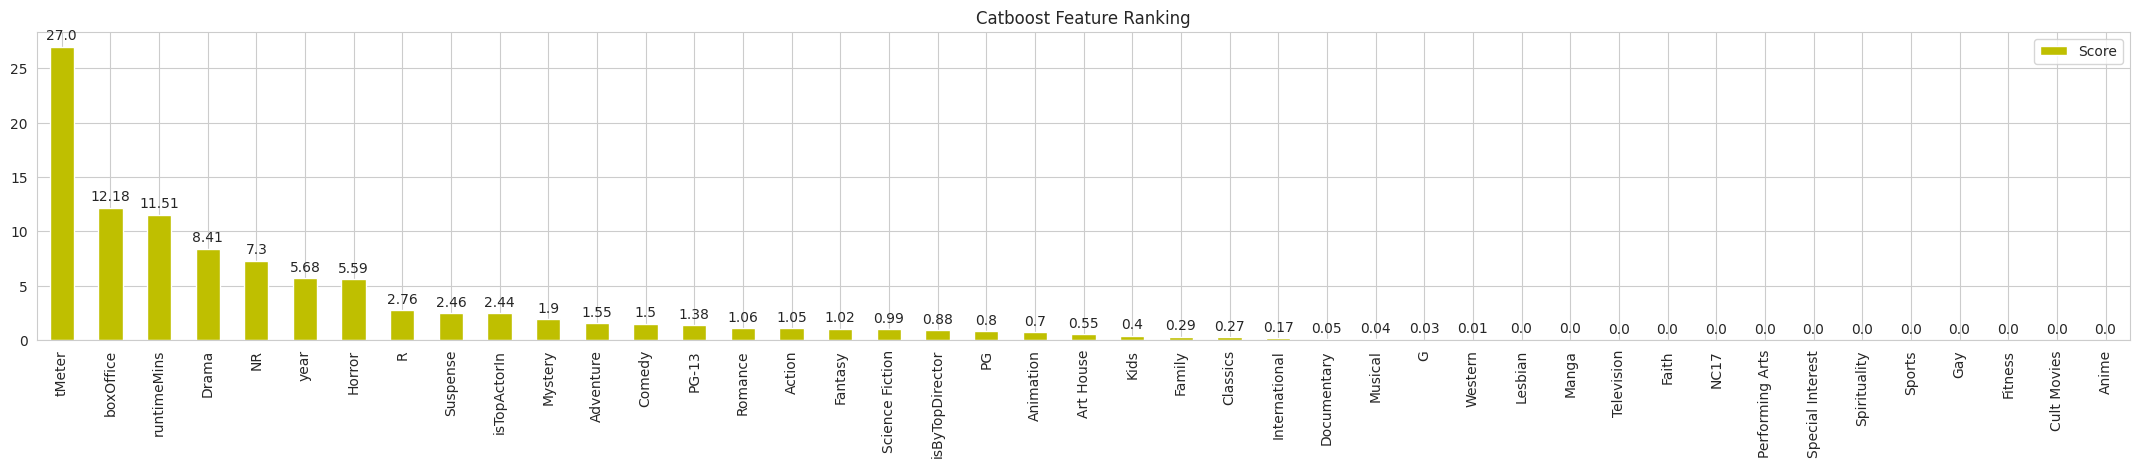

In [376]:
# create plot of feature ranking
# plt.rcParams["figure.figsize"] = (27,4)
fig, ax = plt.subplots(figsize=(27,4))
feature_score.plot('Feature', 'Score', kind='bar', color="y", ax=ax)
ax.set_title("Catboost Feature Ranking")
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

The results differ slightly from what we obtained earlier using `ExtraTreesRegressor`. However, it still maintains `tMeter` as the most important feature.

Next, we use **RandomizedSearchCV** and attempt to find the best parameters for the model.

In [377]:
model = CatBoostRegressor()
parameters = {'depth'         : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [30, 50, 100]
               }
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 3, n_jobs=-1)
grid.fit(X_train, y_train)    

# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    
    
print("\n The best estimator across ALL searched params:\n",grid.best_estimator_)
    
print("\n The best score across ALL searched params:\n",
          grid.best_score_)
    
print("\n The best parameters across ALL searched params:\n",
          grid.best_params_)
    
print("\n ========================================================")



0:	learn: 0.8697853	total: 10.1ms	remaining: 995ms
1:	learn: 0.8348794	total: 16.9ms	remaining: 827ms
2:	learn: 0.8069036	total: 23.1ms	remaining: 747ms
3:	learn: 0.7802219	total: 29.4ms	remaining: 705ms
4:	learn: 0.7585230	total: 35.6ms	remaining: 676ms
5:	learn: 0.7360905	total: 41.7ms	remaining: 654ms
6:	learn: 0.7183708	total: 47.9ms	remaining: 636ms
7:	learn: 0.7019188	total: 54.4ms	remaining: 626ms
8:	learn: 0.6860168	total: 61.1ms	remaining: 618ms
9:	learn: 0.6718006	total: 68ms	remaining: 612ms
10:	learn: 0.6592789	total: 74.4ms	remaining: 602ms
11:	learn: 0.6487700	total: 80.8ms	remaining: 593ms
12:	learn: 0.6387363	total: 87.1ms	remaining: 583ms
13:	learn: 0.6294291	total: 93.5ms	remaining: 574ms
14:	learn: 0.6211534	total: 99.6ms	remaining: 565ms
15:	learn: 0.6131605	total: 106ms	remaining: 556ms
16:	learn: 0.6067985	total: 112ms	remaining: 547ms
17:	learn: 0.6001876	total: 118ms	remaining: 537ms
18:	learn: 0.5944728	total: 124ms	remaining: 529ms
19:	learn: 0.5896541	total: 

========================================================
#### Results from Grid Search 
========================================================

 The best score across ALL searched params:
 0.5729758256482038

 The best parameters across ALL searched params:
  {'depth': 8, 'iterations': 100, 'learning_rate': 0.1}

 ========================================================

<a id='7'></a>

## **Model Evaluation**

Most of the models did fairly well, producing a mean squared error value in the range 0.3-0.4, which appears good enough. Below we produce a summary of the mean squared errors provided by the different models.


  | Algorithm       | MSE | RMSE | $R^2$ Score |
 | -------------:|:-------------|:---------|:------|
| Linear Regerssion      |0.376 | 0.611 | 0.555
| AdaBoost | 0.378     | 0.615 | 0.553 |
| CatBoost | 0.417     | 0.646 | 0.523 |


Overall, it appears the linea regression model did best. We obtained a MSE of 0.376 and a RMSE of 0.611, which seems reasonably good. This means that for each result we get in the prediction, on average the predicted IMDb rating is off by about 0.611. For a rating scale between 1 and 10, this appears quite good.

We also see from the below Residuals vs. Fitted plot for the Linear Regression model that the residuals are well distributed and show no obvious bias.

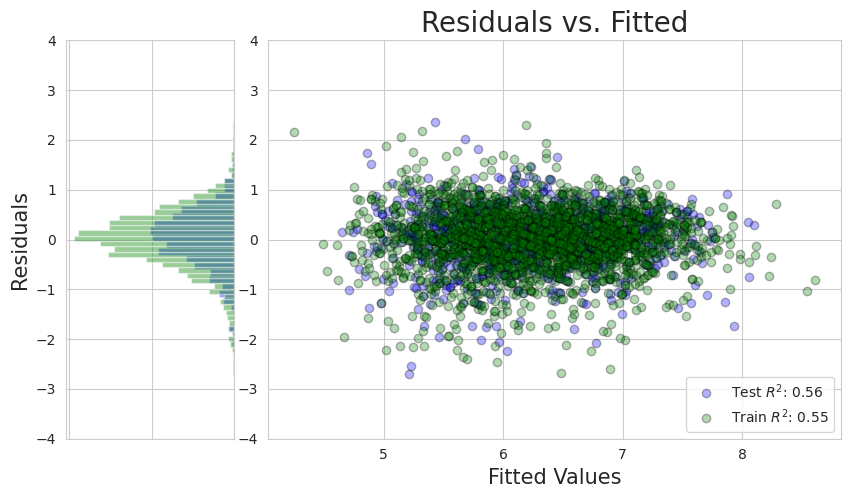

In [378]:
fig = plt.figure(figsize=(10,7))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
x_1_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=42) #Split data
lr.fit(X_tr, y_tr) #Fit model
y_pred_te = lr.predict(X_te) #Obtain predicted values for test set
y_pred_tr = lr.predict(X_tr) #Obtained predicted values for training set

weights_1 = np.ones_like(y_te-y_pred_te)/float(len(y_te-y_pred_te))
weights_2 = np.ones_like(y_tr-y_pred_tr)/float(len(y_tr-y_pred_tr))
r2_score_test = round(r2_score(y_te, y_pred_te), 2)
r2_score_train = round(r2_score(y_tr, y_pred_tr), 2)


main_ax.plot(y_pred_te, y_te-y_pred_te, 'bo', markeredgecolor='black', alpha=0.3)
main_ax.plot(y_pred_tr, y_tr-y_pred_tr, 'go', markeredgecolor='black', alpha=0.3)
sns.distplot(y_te-y_pred_te, ax=x_1_hist, color='blue', vertical=True, kde=False)
sns.distplot(y_tr-y_pred_tr, ax=x_1_hist, color='green', vertical=True, kde=False)
x_1_hist.invert_xaxis()
x_1_hist.grid(True)

main_ax.legend(('Test $R^2$: {}'.format(r2_score_test), 
                'Train $R^2$: {}'.format(r2_score_train)), loc='lower right')

x_1_hist.set_ylabel('Residuals', fontsize=15)
main_ax.set_xlabel('Fitted Values', fontsize=15)
main_ax.set_title('Residuals vs. Fitted', fontsize=20)
main_ax.set_ylim(-4,4)
main_ax.grid(True)
plt.show()

In [379]:
list(zip(lr.coef_, X_te.columns))

[(6.356809730597942e-10, 'boxOffice'),
 (0.019554209369656177, 'tMeter'),
 (0.22564535268502503, 'isTopActorIn'),
 (-0.000822741421578937, 'isByTopDirector'),
 (0.009797142580847927, 'runtimeMins'),
 (-0.023696521402946823, 'Action'),
 (-0.02369652173952631, 'Adventure'),
 (0.386144178756689, 'Animation'),
 (-0.3820680737621718, 'Anime'),
 (0.02184658788672335, 'Art House'),
 (-0.33903676809991723, 'Classics'),
 (-0.07813565886255974, 'Comedy'),
 (-0.5049920781221757, 'Cult Movies'),
 (0.19639476319219115, 'Documentary'),
 (0.15089581524879828, 'Drama'),
 (0.19811764575686638, 'Faith'),
 (-0.023546277535853154, 'Family'),
 (0.002333159132412788, 'Fantasy'),
 (0.08215039359666607, 'Fitness'),
 (0.04959420848750329, 'Gay'),
 (-0.36377191271069687, 'Horror'),
 (0.021846587861583184, 'International'),
 (-0.023546277674645556, 'Kids'),
 (0.04959420850151365, 'Lesbian'),
 (-0.38206807379342106, 'Manga'),
 (-0.09163470720633, 'Musical'),
 (-0.023669480119732664, 'Mystery'),
 (-0.0916347072033

The Linear Regression model coefficients show that a unit increase in a movie's Tomatometer Score increases its IMDb score by 0.0196 while controlling for other variables. Similarly, when a movie is a romance movie, its rating increases by about 0.111, after controlling for other variables. On the other hand, on average, a movie's IMDb score decreases by about 0.024 when the movie is a family movie.

Since, some of the movies are a combination of different types, there may be interaction between some of the variables.

<a id='8'></a>

## References
[1] Galton, F (1907). Vox Populi. Nature. 75 (1949): 450-451

<a id='9'></a>

## **Appendix A**

For each movie hosted on its website, Rotten Tomatoes shares both a Tomatometer Score and an average ratings score, which are provided by critics. While the Tomatometer score is the defining metric on Rotten Tomatoes and is expressed as a percentage (over 100), the average rating score is expressed over 10 and, in theory, shares the same base with the IMDb score we used in this project. However, we believe that there is the correlation between the average rating and the Tomatometer score is strong enough to substitute the former for the latter in our analysis. 

Our project has used the Tomatometer score for all components of the analysis. Hwere in this appendix, we show with a small sample of data collected from the Rotten Tomatoes website that the Tomatometer score is just as good as the average Ratings.

In [380]:
gdd.download_file_from_google_drive(file_id="1bbjoplk90CxcgAy-ug4TJ542CBAV47w7",
                                    dest_path="./rtDataWithAverageRatings.csv",
                                    unzip=False)

In [381]:
rtAvg = pd.read_csv('rtDataWithAverageRatings.csv')

In [382]:
rtAvg.head()

,Unnamed: 0,link,avgRating,tMeter,fresh,ratings
0,0,https://www.rottentomatoes.com/m/game_of_death...,5.77,56.0,15,27
1,1,https://www.rottentomatoes.com/m/milf_2018,3.19,14.0,1,7
2,2,https://www.rottentomatoes.com/m/greyhound,6.49,79.0,154,195
3,3,https://www.rottentomatoes.com/m/we_are_little...,7.71,94.0,44,47
4,4,https://www.rottentomatoes.com/m/the_sunlit_night,4.92,35.0,17,48


Average ratings is expressed as $\frac{fresh}{ratings} * 100$.

For example, for the first instance, this is $\frac{15}{27} * 100 = 55.55 \approx 56$

In [383]:
rtAvg[['avgRating', 'tMeter']].corr()

,avgRating,tMeter
avgRating,1.000000,0.913789
tMeter,0.913789,1.000000


First, we observe that the two variables are highly correlated with a value of 0.914

In [384]:
from scipy.stats import pearsonr
pearsonr(rtAvg.dropna().avgRating, rtAvg.dropna().tMeter)

(0.913788769665673, 3.9500232886564704e-209)

The two-tailed p-value shows that the the correlation coefficient is significant

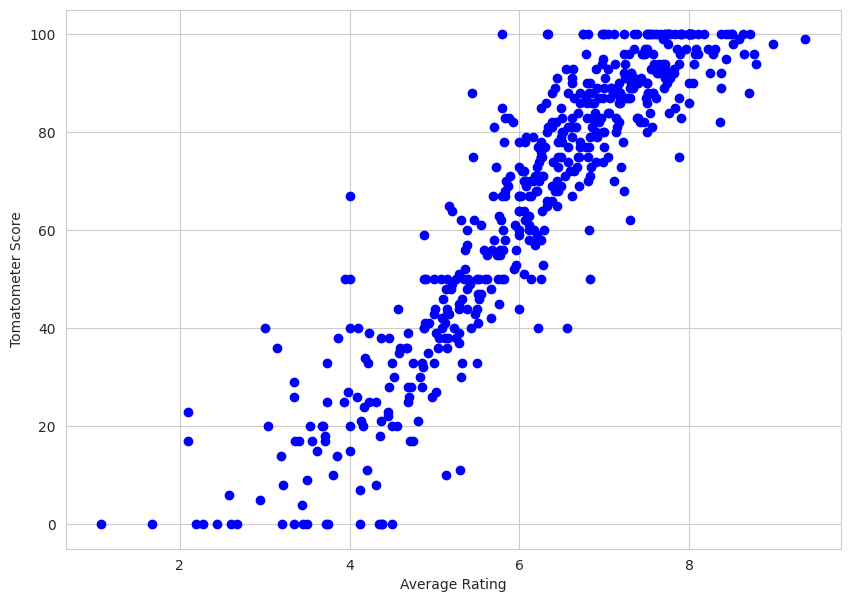

In [385]:
plt.figure(figsize=(10,7))
plt.plot(rtAvg.avgRating, rtAvg.tMeter, 'bo')
plt.ylabel('Tomatometer Score')
plt.xlabel('Average Rating')
plt.show()

The plot shows the linear relationship between the two variables. As one increases, the other does too.

<a id='10'></a>

## **Appendix B**

As an additional task, we examine the prediction of a movie's Tomatometer score using all its Rotten Tomatoes attributes. We consider this an alternative, though secondary task, to our primary task. We check how likely it is that these predictors for each movie instance are good enough to enable us predict their Tomatometer score.

In [386]:
#Obtain predictor and target variables
XX = X.drop(columns="tMeter")
yy = X['tMeter']

In [387]:
XX_tr, XX_te, yy_tr, yy_te  = train_test_split(XX, yy, test_size=0.3, random_state=42)

We use a Random Forest Regressor for the prediction

In [388]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rf = RandomForestRegressor(max_depth=120, n_estimators=100)

In [389]:
#Fit training data

rf.fit(XX_tr, yy_tr)
yy_pred_te = rf.predict(XX_te)

print("MSE: ", mean_squared_error(yy_te, yy_pred_te))
print("RMSE: ", mean_squared_error(yy_te, yy_pred_te) ** (1/2))
print("MAE: ", mean_absolute_error(yy_te, yy_pred_te))
print("R^2 Score: ", r2_score(yy_te, yy_pred_te))

MSE:  607.8603289471895
RMSE:  24.654823644617487
MAE:  20.6961707726203
R^2 Score:  0.0860055048735594


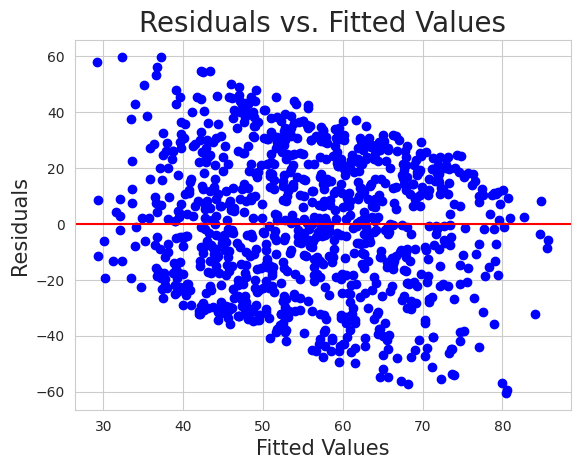

In [390]:
plt.plot(yy_pred_te, yy_te - yy_pred_te, 'bo')
plt.axhline(y=0, color='red')
plt.ylabel('Residuals', fontsize=15)
plt.xlabel('Fitted Values', fontsize=15)
plt.title('Residuals vs. Fitted Values', fontsize=20)
plt.grid(True)
plt.show()

In [391]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

params_ = {'max_depth': np.arange(100,150),
           'min_samples_leaf': np.arange(1,10),
           'n_estimators': np.arange(100,120),
           'min_samples_split': np.arange(2,10)}

rf = RandomForestRegressor(random_state=42)
rscvrf = RandomizedSearchCV(rf, param_distributions=params_)
rscvrf.fit(XX_tr, yy_tr)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                           

In [392]:
y_pred_te = rscvrf.best_estimator_.predict(XX_te)
print("MSE: ", mean_squared_error(yy_te, yy_pred_te))
print("RMSE: ", mean_squared_error(yy_te, yy_pred_te) ** (1/2))
print("MAE: ", mean_absolute_error(yy_te, yy_pred_te))
print("R^2 Score: ", r2_score(yy_te, yy_pred_te))

MSE:  607.8603289471895
RMSE:  24.654823644617487
MAE:  20.6961707726203
R^2 Score:  0.0860055048735594


When we use a linear regressor, w get much better values and a $R^2$ score of 11%

In [393]:
lrr = LinearRegression()
lrr.fit(XX_tr, yy_tr)
yy_pred_te = lrr.predict(XX_te)

print("MSE: ", mean_squared_error(yy_te, yy_pred_te))
print("RMSE: ", mean_squared_error(yy_te, yy_pred_te) ** (1/2))
print("MAE: ", mean_absolute_error(yy_te, yy_pred_te))
print("R^2 Score: ", r2_score(yy_te, yy_pred_te))

MSE:  588.0556105677191
RMSE:  24.249857949433828
MAE:  20.76660483936787
R^2 Score:  0.11578439109848693
